In [ ]:

# Author: Vincent Onodu
from bs4 import BeautifulSoup

#Block of code to loop through and read all dataset files
#Block of code to clean & preprocess the data
#one file is created, the data.json file

def find_closest_rasetype(node):
    while node is not None:
        if node.has_attr('data-rasetype'):
            return node['data-rasetype']
        node = node.parent
    return None


count_map = {}


def run(file) -> tuple:
    with open(file) as f:
        soup = BeautifulSoup(f, "html.parser")

    tags = soup.find_all(lambda tag: tag.has_attr('data-rasetype'))
    cleaned_tags = []

    for tag in tags:
        tags_without_current_tag = tags.copy()
        tags_without_current_tag.remove(tag)

        if not any([tag in t for t in tags_without_current_tag]):
            cleaned_tags.append(tag)

    final_data = []

    for i, tag in enumerate(cleaned_tags):
        test_html = str(tag)

        soup = BeautifulSoup(test_html, "html.parser")

        extracted_data = []
        for element in soup.descendants:

            if element.name is None and element.strip():  # this checks for text nodes
                rasetype = find_closest_rasetype(element.parent)
                extracted_data.append((rasetype, element.strip()))
                if count_map.get(rasetype) is None:
                    count_map[rasetype] = 1
                else:
                    count_map[rasetype] += 1
            else:
                if i == 51 and file == "p.html":
                    if str(element).strip().startswith("<span data-raseproperty"):
                        text = str(element).split("data-raseproperty")[1].replace("=\"", "").split("\"")[0]
                        rasetype = str(element).split("data-rasetype")[1].replace("=\"", "").split("\"")[0]
                        extracted_data.append((rasetype, text))
                        if count_map.get(rasetype) is None:
                            count_map[rasetype] = 1
                        else:
                            count_map[rasetype] += 1

        # first = the first element that has Section else it's just the first element
        first = [(i, x) for i, x in enumerate(extracted_data) if "Section" in x[0]]
        first_index = 0
        if len(first) == 0:
            first = extracted_data[0]
        else:
            first_index = first[0][0]
            first = first[0][1]

        if "Section" in first[0]:
            rasetype = first[0]
            only_type = rasetype.split("Section")[0]

            for i in range(0, len(extracted_data)):
                sub_rasetype = extracted_data[i][0]

                if i == first_index:
                    extracted_data[i] = (f"start-{only_type}", extracted_data[i][1])
                elif sub_rasetype != rasetype:
                    extracted_data[i] = (f"{sub_rasetype[0]}-{only_type}", extracted_data[i][1])
                elif i != len(extracted_data) - 1:
                    extracted_data[i] = (f"inside-{only_type}", extracted_data[i][1])
                else:
                    extracted_data[i] = (f"end-{only_type}", extracted_data[i][1])

        final_data.append(extracted_data)

    tokens = []
    labels = []

    for data in final_data:
        for token in data:
            tokens.append(token[1])
            labels.append(token[0])

    return tokens, labels


array = ["a.html", "b.html", "c.html", "d.html", "e.html", "f.html", "g.html", "h.html", "i.html", "j.html", "k.html",
         "l.html", "m.html", "n.html", "o.html", "p.html", "q.html", "r.html", "s.html", "t.html", "u.html", "v.html",
         "w.html", "x.html", "y.html"]

json_output = []
for i, file in enumerate(array):
    tokens, labels = run(file)
    if len(tokens) != 0:
        json_output.append({"tokens": tokens, "labels": labels})

import json

with open('data.json', 'w') as outfile:
    json.dump(json_output, outfile)

all_labels = [label for json in json_output for label in json["labels"]]
cleaned_up_labels = []
for label in all_labels:
    x = label.split("-")
    if len(x) == 2:
        cleaned_up_labels.append(x[1])
    else:
        cleaned_up_labels.append(x[0])

from collections import Counter

x = (Counter(cleaned_up_labels))
for key, value in x.items():
    print(f"{key}: {value}")

In [ ]:
import json

#Block of code to open the data.json file that was created in the block above
#Block of code to preprocess and transform data into the required format for FLAIR
#Three files are created, the dev.txt, train.txt and test.txt files

def get_reformed_label(previous_label) -> str:
    new = previous_label.split('-')
    if len(new) == 1:
        return previous_label
    new = new[0]
    label_map = {
        'R': 'Requirement',
        'A': 'Application',
        'S': 'Selection',
        'E': 'Exception',
    }
    return label_map[new]


with open('data.json') as f:
    json_data = json.load(f)


cleaned_data = []
for block in json_data:
    tokens = block['tokens']
    labels = block['labels']

    cleaned_tokens = []
    cleaned_labels = []

    for i, token in enumerate(tokens):
        token = token.strip()
        token_split = token.split(' ')

        label = str(labels[i])
        label = label.replace("start-", "")
        label = label.replace("inside-", "")
        label = label.replace("end-", "")

        label = get_reformed_label(label)

        if len(token_split) == 1:
            cleaned_tokens.append(token.replace('\n', '').strip())
            cleaned_labels.append("B-" + label)
            continue

        for j, sub_token in enumerate(token_split):
            cleaned_tokens.append(sub_token.replace('\n', '').strip())
            if j == 0:
                cleaned_labels.append('B-' + label)
            # elif j == len(token_split) - 1:
            #     cleaned_labels.append('E-' + label)
            else:
                cleaned_labels.append('I-' + label)

        cleaned_tokens.append('\n')
        cleaned_labels.append('\n')

    sentences = []
    current_sentence = ""
    for i, token in enumerate(cleaned_tokens):
        if token == '\n':
            sentences.append(current_sentence)
            current_sentence = ""
        else:
            to_add = token + ' ' + cleaned_labels[i] + '\n'
            if len(to_add.strip().split(' ')) <= 1:
                continue
            print(to_add)
            current_sentence += to_add

    cleaned_data += sentences

total = len(cleaned_data)

train = cleaned_data[:int(total * 0.8)]
test = cleaned_data[int(total * 0.8):int(total * 0.9)]
dev = cleaned_data[int(total * 0.9):]

print(len(train))
print(len(test))
print(len(dev))


def write_to_file(file_name, data):
    with open(file_name, 'w') as f:
        for i, sentence in enumerate(data):
            f.write(sentence)
            if i != len(data) - 1:
                f.write('\n')


write_to_file('train.txt', train)
write_to_file('test.txt', test)
write_to_file('dev.txt', dev)

In [ ]:
!pip install flair

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 41.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 60.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 97.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2

In [ ]:
from flair.data import Corpus
from flair.datasets import ColumnCorpus
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer

# Define columns
columns = {0: 'text', 1: 'ner'}

# Directory where the data resides
data_folder = './'

# Corpus with column format
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='train.txt',
                              test_file='test.txt',
                              dev_file='dev.txt')

2023-12-15 20:20:37,508 Reading data from .
2023-12-15 20:20:37,510 Train: train.txt
2023-12-15 20:20:37,511 Dev: dev.txt
2023-12-15 20:20:37,514 Test: test.txt


In [ ]:
print(corpus.train[0].to_tagged_string())

Sentence[2]: "In certain" → ["In certain"/Requirement]


In [ ]:
# Make tag dictionary from the corpus
tag_dictionary = corpus.make_label_dictionary(label_type="ner")
tag_dictionary

2023-12-15 20:20:45,239 Computing label dictionary. Progress:


0it [00:00, ?it/s]
5343it [00:00, 51289.94it/s]

2023-12-15 20:20:45,395 Dictionary created for label 'ner' with 4 values: Requirement (seen 6181 times), Application (seen 1755 times), Exception (seen 729 times), Selection (seen 566 times)


In [ ]:
# Assuming 'tag_dictionary' is your tag dictionary
for tag in tag_dictionary.idx2item:
    print(tag)

b'Requirement'
b'Application'
b'Exception'
b'Selection'


In [ ]:
# Initialize embeddings
embedding_types = [
    WordEmbeddings('glove'),
    # other embeddings if needed
]

embeddings: StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

# Initialize sequence tagger
tagger: SequenceTagger = SequenceTagger(hidden_size=256,
                                        embeddings=embeddings,
                                        tag_dictionary=tag_dictionary,
                                        tag_type='ner',
                                        rnn_layers = 2,
                                        tag_format = "BIO",
                                        use_crf=True)

# Initialize trainer
trainer: ModelTrainer = ModelTrainer(tagger, corpus)

2023-12-15 20:38:37,273 SequenceTagger predicts: Dictionary with 9 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection


In [ ]:

trainer.train(
    base_path='output',
    learning_rate=0.1,  # Initial learning rate
    mini_batch_size=32,
    max_epochs=150,
    anneal_factor=0.8,
    min_learning_rate=0.009
)


2023-12-15 20:38:43,001 ----------------------------------------------------------------------------------------------------
2023-12-15 20:38:43,003 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=100, out_features=100, bias=True)
  (rnn): LSTM(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=512, out_features=11, bias=True)
  (loss_function): ViterbiLoss()
  (crf): CRF()
)"
2023-12-15 20:38:43,004 ----------------------------------------------------------------------------------------------------
2023-12-15 20:38:43,006 Corpus: 5343 train + 535 dev + 534 test sentences
2023-12-15 20:38:43,007 ----------------------------------------------------------------------------------------------------
2023-12-

/usr/local/lib/python3.10/dist-packages/flair/trainers/trainer.py:84: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-12-15 20:38:43,898 epoch 1 - iter 16/167 - loss 1.87420954 - time (sec): 0.86 - samples/sec: 4926.46 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:44,677 epoch 1 - iter 32/167 - loss 1.46238043 - time (sec): 1.64 - samples/sec: 4980.03 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:45,616 epoch 1 - iter 48/167 - loss 1.25883287 - time (sec): 2.58 - samples/sec: 4737.00 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:46,497 epoch 1 - iter 64/167 - loss 1.10011219 - time (sec): 3.46 - samples/sec: 4723.11 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:47,266 epoch 1 - iter 80/167 - loss 1.03836344 - time (sec): 4.23 - samples/sec: 4751.47 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:48,413 epoch 1 - iter 96/167 - loss 0.97525510 - time (sec): 5.38 - samples/sec: 4418.08 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:49,411 epoch 1 - iter 112/167 - loss 0.92454881 - time (sec): 6.37 - samples/sec: 4324.92 - lr: 0.100000 - momentum: 0.000000
2023-

100%|██████████| 9/9 [00:00<00:00, 12.58it/s]


2023-12-15 20:38:52,667 DEV : loss 0.5595788955688477 - f1-score (micro avg)  0.3074
2023-12-15 20:38:52,688  - 0 epochs without improvement
2023-12-15 20:38:52,689 saving best model
2023-12-15 20:38:53,385 ----------------------------------------------------------------------------------------------------
2023-12-15 20:38:54,245 epoch 2 - iter 16/167 - loss 0.47160775 - time (sec): 0.86 - samples/sec: 4597.53 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:54,956 epoch 2 - iter 32/167 - loss 0.46830095 - time (sec): 1.57 - samples/sec: 4976.62 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:55,811 epoch 2 - iter 48/167 - loss 0.46629544 - time (sec): 2.42 - samples/sec: 4985.50 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:56,558 epoch 2 - iter 64/167 - loss 0.47595327 - time (sec): 3.17 - samples/sec: 4990.64 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:38:57,216 epoch 2 - iter 80/167 - loss 0.47951848 - time (sec): 3.83 - samples/sec: 5103.03 - lr: 0.100000 - m

100%|██████████| 9/9 [00:00<00:00, 10.44it/s]

2023-12-15 20:39:03,101 DEV : loss 0.46703246235847473 - f1-score (micro avg)  0.298
2023-12-15 20:39:03,117  - 1 epochs without improvement
2023-12-15 20:39:03,118 ----------------------------------------------------------------------------------------------------


2023-12-15 20:39:03,841 epoch 3 - iter 16/167 - loss 0.41071278 - time (sec): 0.72 - samples/sec: 5229.46 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:04,580 epoch 3 - iter 32/167 - loss 0.42257549 - time (sec): 1.46 - samples/sec: 5268.62 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:05,261 epoch 3 - iter 48/167 - loss 0.42217828 - time (sec): 2.14 - samples/sec: 5307.30 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:06,134 epoch 3 - iter 64/167 - loss 0.41197804 - time (sec): 3.01 - samples/sec: 5174.93 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:06,845 epoch 3 - iter 80/167 - loss 0.40984429 - time (sec): 3.72 - samples/sec: 5193.58 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:07,501 epoch 3 - iter 96/167 - loss 0.41734991 - time (sec): 4.38 - samples/sec: 5258.71 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:08,269 epoch 3 - iter 112/167 - loss 0.41120480 - time (sec): 5.15 - samples/sec: 5218.09 - lr: 0.100000 - momentum: 0.000000
2023-

100%|██████████| 9/9 [00:00<00:00, 12.26it/s]

2023-12-15 20:39:11,931 DEV : loss 0.436918169260025 - f1-score (micro avg)  0.3717
2023-12-15 20:39:11,947  - 0 epochs without improvement
2023-12-15 20:39:11,948 saving best model


2023-12-15 20:39:12,732 ----------------------------------------------------------------------------------------------------
2023-12-15 20:39:13,735 epoch 4 - iter 16/167 - loss 0.44588714 - time (sec): 1.00 - samples/sec: 3769.19 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:14,798 epoch 4 - iter 32/167 - loss 0.42035168 - time (sec): 2.06 - samples/sec: 3644.97 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:15,744 epoch 4 - iter 48/167 - loss 0.39506108 - time (sec): 3.01 - samples/sec: 3867.97 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:16,578 epoch 4 - iter 64/167 - loss 0.38373610 - time (sec): 3.84 - samples/sec: 4026.42 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:17,273 epoch 4 - iter 80/167 - loss 0.38941910 - time (sec): 4.54 - samples/sec: 4234.97 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:18,005 epoch 4 - iter 96/167 - loss 0.39026520 - time (sec): 5.27 - samples/sec: 4378.66 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:18,897

100%|██████████| 9/9 [00:00<00:00, 12.60it/s]

2023-12-15 20:39:22,358 DEV : loss 0.4138745367527008 - f1-score (micro avg)  0.2981
2023-12-15 20:39:22,373  - 1 epochs without improvement
2023-12-15 20:39:22,375 ----------------------------------------------------------------------------------------------------


2023-12-15 20:39:23,361 epoch 5 - iter 16/167 - loss 0.35602045 - time (sec): 0.98 - samples/sec: 4259.23 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:24,175 epoch 5 - iter 32/167 - loss 0.36438542 - time (sec): 1.80 - samples/sec: 4535.86 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:25,004 epoch 5 - iter 48/167 - loss 0.37329983 - time (sec): 2.63 - samples/sec: 4637.09 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:25,846 epoch 5 - iter 64/167 - loss 0.37093882 - time (sec): 3.47 - samples/sec: 4593.21 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:26,729 epoch 5 - iter 80/167 - loss 0.37684670 - time (sec): 4.35 - samples/sec: 4461.85 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:27,801 epoch 5 - iter 96/167 - loss 0.37499266 - time (sec): 5.42 - samples/sec: 4253.50 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:28,636 epoch 5 - iter 112/167 - loss 0.36768777 - time (sec): 6.26 - samples/sec: 4286.40 - lr: 0.100000 - momentum: 0.000000
2023-

100%|██████████| 9/9 [00:00<00:00, 12.55it/s]

2023-12-15 20:39:32,044 DEV : loss 0.37528133392333984 - f1-score (micro avg)  0.4132
2023-12-15 20:39:32,060  - 0 epochs without improvement
2023-12-15 20:39:32,061 saving best model


2023-12-15 20:39:32,814 ----------------------------------------------------------------------------------------------------
2023-12-15 20:39:33,747 epoch 6 - iter 16/167 - loss 0.32999336 - time (sec): 0.93 - samples/sec: 4444.54 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:34,464 epoch 6 - iter 32/167 - loss 0.35700880 - time (sec): 1.65 - samples/sec: 4828.55 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:35,203 epoch 6 - iter 48/167 - loss 0.35729622 - time (sec): 2.39 - samples/sec: 4959.06 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:35,917 epoch 6 - iter 64/167 - loss 0.36030538 - time (sec): 3.10 - samples/sec: 5024.90 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:36,700 epoch 6 - iter 80/167 - loss 0.35941586 - time (sec): 3.88 - samples/sec: 5038.12 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:37,509 epoch 6 - iter 96/167 - loss 0.35753646 - time (sec): 4.69 - samples/sec: 5000.74 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:38,418

100%|██████████| 9/9 [00:00<00:00, 12.36it/s]

2023-12-15 20:39:42,325 DEV : loss 0.40221428871154785 - f1-score (micro avg)  0.4352
2023-12-15 20:39:42,342  - 0 epochs without improvement
2023-12-15 20:39:42,343 saving best model


2023-12-15 20:39:43,110 ----------------------------------------------------------------------------------------------------
2023-12-15 20:39:43,883 epoch 7 - iter 16/167 - loss 0.37825354 - time (sec): 0.77 - samples/sec: 4724.58 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:44,684 epoch 7 - iter 32/167 - loss 0.38773504 - time (sec): 1.57 - samples/sec: 4839.50 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:45,519 epoch 7 - iter 48/167 - loss 0.36639212 - time (sec): 2.40 - samples/sec: 4800.53 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:46,253 epoch 7 - iter 64/167 - loss 0.35997824 - time (sec): 3.14 - samples/sec: 4841.06 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:47,139 epoch 7 - iter 80/167 - loss 0.35550783 - time (sec): 4.02 - samples/sec: 4850.39 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:47,892 epoch 7 - iter 96/167 - loss 0.35560268 - time (sec): 4.78 - samples/sec: 4893.62 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:48,647

100%|██████████| 9/9 [00:01<00:00,  7.94it/s]


2023-12-15 20:39:52,737 DEV : loss 0.3539113700389862 - f1-score (micro avg)  0.4991
2023-12-15 20:39:52,761  - 0 epochs without improvement
2023-12-15 20:39:52,763 saving best model
2023-12-15 20:39:53,862 ----------------------------------------------------------------------------------------------------
2023-12-15 20:39:54,607 epoch 8 - iter 16/167 - loss 0.40083195 - time (sec): 0.74 - samples/sec: 4957.20 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:55,387 epoch 8 - iter 32/167 - loss 0.36194720 - time (sec): 1.52 - samples/sec: 4929.23 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:56,140 epoch 8 - iter 48/167 - loss 0.34985342 - time (sec): 2.27 - samples/sec: 4987.81 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:56,878 epoch 8 - iter 64/167 - loss 0.35158524 - time (sec): 3.01 - samples/sec: 5099.14 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:39:57,592 epoch 8 - iter 80/167 - loss 0.35854263 - time (sec): 3.73 - samples/sec: 5121.50 - lr: 0.100000 - m

100%|██████████| 9/9 [00:00<00:00, 12.53it/s]


2023-12-15 20:40:02,777 DEV : loss 0.389080286026001 - f1-score (micro avg)  0.3929
2023-12-15 20:40:02,796  - 1 epochs without improvement
2023-12-15 20:40:02,797 ----------------------------------------------------------------------------------------------------
2023-12-15 20:40:03,711 epoch 9 - iter 16/167 - loss 0.33202551 - time (sec): 0.91 - samples/sec: 4143.55 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:04,662 epoch 9 - iter 32/167 - loss 0.35750061 - time (sec): 1.86 - samples/sec: 4065.47 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:05,818 epoch 9 - iter 48/167 - loss 0.34998669 - time (sec): 3.02 - samples/sec: 3808.75 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:06,765 epoch 9 - iter 64/167 - loss 0.33654488 - time (sec): 3.96 - samples/sec: 3928.59 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:07,506 epoch 9 - iter 80/167 - loss 0.33819440 - time (sec): 4.71 - samples/sec: 4110.26 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:08,159 e

100%|██████████| 9/9 [00:00<00:00, 12.43it/s]

2023-12-15 20:40:12,430 DEV : loss 0.4492616355419159 - f1-score (micro avg)  0.4269
2023-12-15 20:40:12,445  - 2 epochs without improvement
2023-12-15 20:40:12,447 ----------------------------------------------------------------------------------------------------


2023-12-15 20:40:13,217 epoch 10 - iter 16/167 - loss 0.32279364 - time (sec): 0.77 - samples/sec: 5081.87 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:14,030 epoch 10 - iter 32/167 - loss 0.32796746 - time (sec): 1.58 - samples/sec: 4888.76 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:14,816 epoch 10 - iter 48/167 - loss 0.32144566 - time (sec): 2.37 - samples/sec: 4969.04 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:15,495 epoch 10 - iter 64/167 - loss 0.33311715 - time (sec): 3.05 - samples/sec: 5083.39 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:16,365 epoch 10 - iter 80/167 - loss 0.33664383 - time (sec): 3.92 - samples/sec: 4947.06 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:17,368 epoch 10 - iter 96/167 - loss 0.33890064 - time (sec): 4.92 - samples/sec: 4687.35 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:18,270 epoch 10 - iter 112/167 - loss 0.33848346 - time (sec): 5.82 - samples/sec: 4579.93 - lr: 0.100000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

2023-12-15 20:40:22,037 DEV : loss 0.33801892399787903 - f1-score (micro avg)  0.5952
2023-12-15 20:40:22,053  - 0 epochs without improvement
2023-12-15 20:40:22,054 saving best model


2023-12-15 20:40:22,835 ----------------------------------------------------------------------------------------------------
2023-12-15 20:40:23,654 epoch 11 - iter 16/167 - loss 0.36794968 - time (sec): 0.81 - samples/sec: 4536.65 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:24,575 epoch 11 - iter 32/167 - loss 0.33892940 - time (sec): 1.74 - samples/sec: 4566.83 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:25,277 epoch 11 - iter 48/167 - loss 0.34094645 - time (sec): 2.44 - samples/sec: 4833.81 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:25,973 epoch 11 - iter 64/167 - loss 0.33819064 - time (sec): 3.13 - samples/sec: 4981.58 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:26,680 epoch 11 - iter 80/167 - loss 0.33768632 - time (sec): 3.84 - samples/sec: 5012.69 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:27,500 epoch 11 - iter 96/167 - loss 0.33446862 - time (sec): 4.66 - samples/sec: 4993.04 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:

100%|██████████| 9/9 [00:00<00:00, 12.47it/s]


2023-12-15 20:40:32,322 DEV : loss 0.3638891577720642 - f1-score (micro avg)  0.5372
2023-12-15 20:40:32,337  - 1 epochs without improvement
2023-12-15 20:40:32,338 ----------------------------------------------------------------------------------------------------
2023-12-15 20:40:33,121 epoch 12 - iter 16/167 - loss 0.30694773 - time (sec): 0.78 - samples/sec: 4991.89 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:33,776 epoch 12 - iter 32/167 - loss 0.30920658 - time (sec): 1.43 - samples/sec: 5315.73 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:34,480 epoch 12 - iter 48/167 - loss 0.32524512 - time (sec): 2.14 - samples/sec: 5322.17 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:35,495 epoch 12 - iter 64/167 - loss 0.31448006 - time (sec): 3.15 - samples/sec: 4965.61 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:36,129 epoch 12 - iter 80/167 - loss 0.32591917 - time (sec): 3.79 - samples/sec: 5087.38 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:36

100%|██████████| 9/9 [00:00<00:00, 12.38it/s]


2023-12-15 20:40:41,650 DEV : loss 0.3212113380432129 - f1-score (micro avg)  0.5492
2023-12-15 20:40:41,674  - 2 epochs without improvement
2023-12-15 20:40:41,679 ----------------------------------------------------------------------------------------------------
2023-12-15 20:40:42,807 epoch 13 - iter 16/167 - loss 0.30852870 - time (sec): 1.13 - samples/sec: 3548.05 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:43,848 epoch 13 - iter 32/167 - loss 0.31822265 - time (sec): 2.17 - samples/sec: 3555.27 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:44,667 epoch 13 - iter 48/167 - loss 0.32624172 - time (sec): 2.99 - samples/sec: 3869.34 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:45,466 epoch 13 - iter 64/167 - loss 0.32956556 - time (sec): 3.78 - samples/sec: 4068.96 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:46,242 epoch 13 - iter 80/167 - loss 0.33570499 - time (sec): 4.56 - samples/sec: 4190.66 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:47

100%|██████████| 9/9 [00:00<00:00, 12.42it/s]

2023-12-15 20:40:51,131 DEV : loss 0.30418410897254944 - f1-score (micro avg)  0.6155
2023-12-15 20:40:51,147  - 0 epochs without improvement
2023-12-15 20:40:51,148 saving best model


2023-12-15 20:40:52,084 ----------------------------------------------------------------------------------------------------
2023-12-15 20:40:52,789 epoch 14 - iter 16/167 - loss 0.32009833 - time (sec): 0.70 - samples/sec: 5337.08 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:53,679 epoch 14 - iter 32/167 - loss 0.31516789 - time (sec): 1.59 - samples/sec: 4756.39 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:54,772 epoch 14 - iter 48/167 - loss 0.31175808 - time (sec): 2.68 - samples/sec: 4272.57 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:55,840 epoch 14 - iter 64/167 - loss 0.30600455 - time (sec): 3.75 - samples/sec: 4152.96 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:56,949 epoch 14 - iter 80/167 - loss 0.30836668 - time (sec): 4.86 - samples/sec: 4017.44 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:57,618 epoch 14 - iter 96/167 - loss 0.30857127 - time (sec): 5.53 - samples/sec: 4195.39 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:40:

100%|██████████| 9/9 [00:00<00:00, 12.38it/s]

2023-12-15 20:41:01,936 DEV : loss 0.31809455156326294 - f1-score (micro avg)  0.5573
2023-12-15 20:41:01,952  - 1 epochs without improvement
2023-12-15 20:41:01,954 ----------------------------------------------------------------------------------------------------


2023-12-15 20:41:02,703 epoch 15 - iter 16/167 - loss 0.29943532 - time (sec): 0.75 - samples/sec: 5542.64 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:03,460 epoch 15 - iter 32/167 - loss 0.31358695 - time (sec): 1.50 - samples/sec: 5217.35 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:04,261 epoch 15 - iter 48/167 - loss 0.32038176 - time (sec): 2.30 - samples/sec: 5109.05 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:05,195 epoch 15 - iter 64/167 - loss 0.31885146 - time (sec): 3.24 - samples/sec: 4896.35 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:05,984 epoch 15 - iter 80/167 - loss 0.32379582 - time (sec): 4.03 - samples/sec: 4881.11 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:06,646 epoch 15 - iter 96/167 - loss 0.32341657 - time (sec): 4.69 - samples/sec: 4961.60 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:07,752 epoch 15 - iter 112/167 - loss 0.32302034 - time (sec): 5.80 - samples/sec: 4679.08 - lr: 0.100000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.32it/s]

2023-12-15 20:41:11,565 DEV : loss 0.29536640644073486 - f1-score (micro avg)  0.6147
2023-12-15 20:41:11,581  - 2 epochs without improvement
2023-12-15 20:41:11,582 ----------------------------------------------------------------------------------------------------


2023-12-15 20:41:12,393 epoch 16 - iter 16/167 - loss 0.29575471 - time (sec): 0.81 - samples/sec: 4687.90 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:13,096 epoch 16 - iter 32/167 - loss 0.29620734 - time (sec): 1.51 - samples/sec: 4940.11 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:13,741 epoch 16 - iter 48/167 - loss 0.29942630 - time (sec): 2.16 - samples/sec: 5131.56 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:14,870 epoch 16 - iter 64/167 - loss 0.29600610 - time (sec): 3.28 - samples/sec: 4737.03 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:15,830 epoch 16 - iter 80/167 - loss 0.29802830 - time (sec): 4.24 - samples/sec: 4650.97 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:16,548 epoch 16 - iter 96/167 - loss 0.30074355 - time (sec): 4.96 - samples/sec: 4748.03 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:17,249 epoch 16 - iter 112/167 - loss 0.30677209 - time (sec): 5.66 - samples/sec: 4806.88 - lr: 0.100000 - momentum: 0.00000

100%|██████████| 9/9 [00:01<00:00,  8.04it/s]


2023-12-15 20:41:20,994 DEV : loss 0.3000204861164093 - f1-score (micro avg)  0.6139
2023-12-15 20:41:21,020  - 3 epochs without improvement
2023-12-15 20:41:21,024 ----------------------------------------------------------------------------------------------------
2023-12-15 20:41:22,094 epoch 17 - iter 16/167 - loss 0.32117175 - time (sec): 1.07 - samples/sec: 3601.04 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:22,729 epoch 17 - iter 32/167 - loss 0.31365342 - time (sec): 1.70 - samples/sec: 4443.72 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:23,439 epoch 17 - iter 48/167 - loss 0.31747789 - time (sec): 2.41 - samples/sec: 4681.85 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:24,187 epoch 17 - iter 64/167 - loss 0.32246730 - time (sec): 3.16 - samples/sec: 4778.47 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:24,987 epoch 17 - iter 80/167 - loss 0.32033415 - time (sec): 3.96 - samples/sec: 4780.56 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:25

100%|██████████| 9/9 [00:00<00:00, 12.51it/s]


2023-12-15 20:41:30,207 DEV : loss 0.2939640283584595 - f1-score (micro avg)  0.652
2023-12-15 20:41:30,225  - 0 epochs without improvement
2023-12-15 20:41:30,227 saving best model
2023-12-15 20:41:31,007 ----------------------------------------------------------------------------------------------------
2023-12-15 20:41:31,828 epoch 18 - iter 16/167 - loss 0.34533261 - time (sec): 0.82 - samples/sec: 4649.23 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:33,209 epoch 18 - iter 32/167 - loss 0.31181360 - time (sec): 2.20 - samples/sec: 3723.85 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:34,261 epoch 18 - iter 48/167 - loss 0.30944667 - time (sec): 3.25 - samples/sec: 3652.65 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:35,140 epoch 18 - iter 64/167 - loss 0.30714265 - time (sec): 4.13 - samples/sec: 3787.85 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:35,980 epoch 18 - iter 80/167 - loss 0.31177376 - time (sec): 4.97 - samples/sec: 3940.55 - lr: 0.100000

100%|██████████| 9/9 [00:00<00:00, 12.68it/s]

2023-12-15 20:41:40,782 DEV : loss 0.2851259410381317 - f1-score (micro avg)  0.6027
2023-12-15 20:41:40,801  - 1 epochs without improvement
2023-12-15 20:41:40,803 ----------------------------------------------------------------------------------------------------


2023-12-15 20:41:41,530 epoch 19 - iter 16/167 - loss 0.30046858 - time (sec): 0.72 - samples/sec: 5366.59 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:42,187 epoch 19 - iter 32/167 - loss 0.32241034 - time (sec): 1.38 - samples/sec: 5468.95 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:42,906 epoch 19 - iter 48/167 - loss 0.33245601 - time (sec): 2.10 - samples/sec: 5433.56 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:43,913 epoch 19 - iter 64/167 - loss 0.32418974 - time (sec): 3.11 - samples/sec: 5035.46 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:44,731 epoch 19 - iter 80/167 - loss 0.32393327 - time (sec): 3.93 - samples/sec: 4962.12 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:45,889 epoch 19 - iter 96/167 - loss 0.32369448 - time (sec): 5.08 - samples/sec: 4571.32 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:46,769 epoch 19 - iter 112/167 - loss 0.32047895 - time (sec): 5.96 - samples/sec: 4498.42 - lr: 0.100000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.44it/s]


2023-12-15 20:41:50,357 DEV : loss 0.2761172950267792 - f1-score (micro avg)  0.6171
2023-12-15 20:41:50,372  - 2 epochs without improvement
2023-12-15 20:41:50,374 ----------------------------------------------------------------------------------------------------
2023-12-15 20:41:51,049 epoch 20 - iter 16/167 - loss 0.31504831 - time (sec): 0.67 - samples/sec: 5470.30 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:51,917 epoch 20 - iter 32/167 - loss 0.30682079 - time (sec): 1.54 - samples/sec: 5005.26 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:52,687 epoch 20 - iter 48/167 - loss 0.30573386 - time (sec): 2.31 - samples/sec: 5098.79 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:53,535 epoch 20 - iter 64/167 - loss 0.30196022 - time (sec): 3.16 - samples/sec: 4984.50 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:54,360 epoch 20 - iter 80/167 - loss 0.30177073 - time (sec): 3.98 - samples/sec: 4961.79 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:41:55

100%|██████████| 9/9 [00:01<00:00,  8.27it/s]

2023-12-15 20:42:00,127 DEV : loss 0.27559465169906616 - f1-score (micro avg)  0.6408
2023-12-15 20:42:00,142  - 3 epochs without improvement
2023-12-15 20:42:00,143 ----------------------------------------------------------------------------------------------------


2023-12-15 20:42:00,938 epoch 21 - iter 16/167 - loss 0.31846360 - time (sec): 0.79 - samples/sec: 4793.92 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:42:01,616 epoch 21 - iter 32/167 - loss 0.31583571 - time (sec): 1.47 - samples/sec: 5074.87 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:42:02,590 epoch 21 - iter 48/167 - loss 0.31237007 - time (sec): 2.44 - samples/sec: 4664.86 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:42:03,380 epoch 21 - iter 64/167 - loss 0.31054714 - time (sec): 3.23 - samples/sec: 4709.52 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:42:04,054 epoch 21 - iter 80/167 - loss 0.30559754 - time (sec): 3.91 - samples/sec: 4867.41 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:42:04,749 epoch 21 - iter 96/167 - loss 0.31004080 - time (sec): 4.60 - samples/sec: 4963.12 - lr: 0.100000 - momentum: 0.000000
2023-12-15 20:42:05,570 epoch 21 - iter 112/167 - loss 0.30269278 - time (sec): 5.42 - samples/sec: 4922.37 - lr: 0.100000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.26it/s]

2023-12-15 20:42:09,015 DEV : loss 0.293910413980484 - f1-score (micro avg)  0.6313
2023-12-15 20:42:09,030  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.08000000000000002]
2023-12-15 20:42:09,032 ----------------------------------------------------------------------------------------------------


2023-12-15 20:42:09,929 epoch 22 - iter 16/167 - loss 0.28562385 - time (sec): 0.89 - samples/sec: 4543.15 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:10,940 epoch 22 - iter 32/167 - loss 0.28364339 - time (sec): 1.91 - samples/sec: 4093.90 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:11,906 epoch 22 - iter 48/167 - loss 0.28636703 - time (sec): 2.87 - samples/sec: 4000.97 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:12,952 epoch 22 - iter 64/167 - loss 0.28322203 - time (sec): 3.92 - samples/sec: 3926.14 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:13,724 epoch 22 - iter 80/167 - loss 0.28299362 - time (sec): 4.69 - samples/sec: 4106.15 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:14,673 epoch 22 - iter 96/167 - loss 0.27746029 - time (sec): 5.64 - samples/sec: 4157.33 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:15,516 epoch 22 - iter 112/167 - loss 0.27612826 - time (sec): 6.48 - samples/sec: 4232.33 - lr: 0.080000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.68it/s]


2023-12-15 20:42:18,681 DEV : loss 0.2576671838760376 - f1-score (micro avg)  0.6692
2023-12-15 20:42:18,698  - 0 epochs without improvement
2023-12-15 20:42:18,699 saving best model
2023-12-15 20:42:19,469 ----------------------------------------------------------------------------------------------------
2023-12-15 20:42:20,385 epoch 23 - iter 16/167 - loss 0.28156285 - time (sec): 0.91 - samples/sec: 4228.82 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:21,235 epoch 23 - iter 32/167 - loss 0.27592736 - time (sec): 1.76 - samples/sec: 4427.14 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:22,285 epoch 23 - iter 48/167 - loss 0.27353126 - time (sec): 2.81 - samples/sec: 4160.07 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:23,561 epoch 23 - iter 64/167 - loss 0.27091456 - time (sec): 4.09 - samples/sec: 3812.62 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:24,798 epoch 23 - iter 80/167 - loss 0.27776172 - time (sec): 5.32 - samples/sec: 3642.34 - lr: 0.08000

100%|██████████| 9/9 [00:00<00:00, 12.32it/s]

2023-12-15 20:42:30,538 DEV : loss 0.25588834285736084 - f1-score (micro avg)  0.6561
2023-12-15 20:42:30,555  - 1 epochs without improvement
2023-12-15 20:42:30,557 ----------------------------------------------------------------------------------------------------


2023-12-15 20:42:31,560 epoch 24 - iter 16/167 - loss 0.24846913 - time (sec): 1.00 - samples/sec: 4022.66 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:32,223 epoch 24 - iter 32/167 - loss 0.26864563 - time (sec): 1.66 - samples/sec: 4596.71 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:32,876 epoch 24 - iter 48/167 - loss 0.27173691 - time (sec): 2.32 - samples/sec: 4877.24 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:33,489 epoch 24 - iter 64/167 - loss 0.27614076 - time (sec): 2.93 - samples/sec: 5054.34 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:34,217 epoch 24 - iter 80/167 - loss 0.27422852 - time (sec): 3.66 - samples/sec: 5153.69 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:34,946 epoch 24 - iter 96/167 - loss 0.27752831 - time (sec): 4.39 - samples/sec: 5194.86 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:35,890 epoch 24 - iter 112/167 - loss 0.27822337 - time (sec): 5.33 - samples/sec: 5039.31 - lr: 0.080000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.49it/s]

2023-12-15 20:42:40,200 DEV : loss 0.26047077775001526 - f1-score (micro avg)  0.6533
2023-12-15 20:42:40,217  - 2 epochs without improvement
2023-12-15 20:42:40,219 ----------------------------------------------------------------------------------------------------


2023-12-15 20:42:40,901 epoch 25 - iter 16/167 - loss 0.29704676 - time (sec): 0.68 - samples/sec: 5227.43 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:41,663 epoch 25 - iter 32/167 - loss 0.27956306 - time (sec): 1.44 - samples/sec: 5108.89 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:42,528 epoch 25 - iter 48/167 - loss 0.26975652 - time (sec): 2.31 - samples/sec: 4925.09 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:43,248 epoch 25 - iter 64/167 - loss 0.27599668 - time (sec): 3.03 - samples/sec: 4930.42 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:43,951 epoch 25 - iter 80/167 - loss 0.27725898 - time (sec): 3.73 - samples/sec: 5058.19 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:44,619 epoch 25 - iter 96/167 - loss 0.28177375 - time (sec): 4.40 - samples/sec: 5133.61 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:45,440 epoch 25 - iter 112/167 - loss 0.27915278 - time (sec): 5.22 - samples/sec: 5082.34 - lr: 0.080000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.18it/s]

2023-12-15 20:42:49,085 DEV : loss 0.2419538050889969 - f1-score (micro avg)  0.6692
2023-12-15 20:42:49,103  - 3 epochs without improvement
2023-12-15 20:42:49,105 ----------------------------------------------------------------------------------------------------


2023-12-15 20:42:49,959 epoch 26 - iter 16/167 - loss 0.30337254 - time (sec): 0.85 - samples/sec: 4403.74 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:51,143 epoch 26 - iter 32/167 - loss 0.28635596 - time (sec): 2.04 - samples/sec: 3752.84 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:52,145 epoch 26 - iter 48/167 - loss 0.28601838 - time (sec): 3.04 - samples/sec: 3696.81 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:52,846 epoch 26 - iter 64/167 - loss 0.28640900 - time (sec): 3.74 - samples/sec: 3996.13 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:53,664 epoch 26 - iter 80/167 - loss 0.28012523 - time (sec): 4.56 - samples/sec: 4152.72 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:54,785 epoch 26 - iter 96/167 - loss 0.27754536 - time (sec): 5.68 - samples/sec: 4112.36 - lr: 0.080000 - momentum: 0.000000
2023-12-15 20:42:55,583 epoch 26 - iter 112/167 - loss 0.27670298 - time (sec): 6.48 - samples/sec: 4204.35 - lr: 0.080000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

2023-12-15 20:42:58,900 DEV : loss 0.3228808641433716 - f1-score (micro avg)  0.567
2023-12-15 20:42:58,916  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.06400000000000002]
2023-12-15 20:42:58,917 ----------------------------------------------------------------------------------------------------


2023-12-15 20:42:59,749 epoch 27 - iter 16/167 - loss 0.29023221 - time (sec): 0.83 - samples/sec: 4623.07 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:00,407 epoch 27 - iter 32/167 - loss 0.27822566 - time (sec): 1.49 - samples/sec: 5079.53 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:01,168 epoch 27 - iter 48/167 - loss 0.26553019 - time (sec): 2.25 - samples/sec: 5073.20 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:01,991 epoch 27 - iter 64/167 - loss 0.27062811 - time (sec): 3.07 - samples/sec: 4968.18 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:03,083 epoch 27 - iter 80/167 - loss 0.27092513 - time (sec): 4.16 - samples/sec: 4645.66 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:04,376 epoch 27 - iter 96/167 - loss 0.26842413 - time (sec): 5.46 - samples/sec: 4266.07 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:05,223 epoch 27 - iter 112/167 - loss 0.26854138 - time (sec): 6.30 - samples/sec: 4270.29 - lr: 0.064000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.45it/s]

2023-12-15 20:43:08,601 DEV : loss 0.2432195395231247 - f1-score (micro avg)  0.6787
2023-12-15 20:43:08,617  - 0 epochs without improvement
2023-12-15 20:43:08,618 saving best model


2023-12-15 20:43:09,412 ----------------------------------------------------------------------------------------------------
2023-12-15 20:43:10,414 epoch 28 - iter 16/167 - loss 0.25651138 - time (sec): 0.99 - samples/sec: 4076.95 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:11,101 epoch 28 - iter 32/167 - loss 0.26225687 - time (sec): 1.68 - samples/sec: 4550.99 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:12,105 epoch 28 - iter 48/167 - loss 0.25385196 - time (sec): 2.69 - samples/sec: 4386.21 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:12,752 epoch 28 - iter 64/167 - loss 0.26127504 - time (sec): 3.33 - samples/sec: 4614.75 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:13,596 epoch 28 - iter 80/167 - loss 0.25801421 - time (sec): 4.18 - samples/sec: 4665.47 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:14,310 epoch 28 - iter 96/167 - loss 0.26231028 - time (sec): 4.89 - samples/sec: 4760.35 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:

100%|██████████| 9/9 [00:00<00:00, 12.40it/s]

2023-12-15 20:43:19,041 DEV : loss 0.22948583960533142 - f1-score (micro avg)  0.6703
2023-12-15 20:43:19,058  - 1 epochs without improvement
2023-12-15 20:43:19,059 ----------------------------------------------------------------------------------------------------


2023-12-15 20:43:19,868 epoch 29 - iter 16/167 - loss 0.26318490 - time (sec): 0.81 - samples/sec: 4682.00 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:20,671 epoch 29 - iter 32/167 - loss 0.26203662 - time (sec): 1.61 - samples/sec: 4866.25 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:21,441 epoch 29 - iter 48/167 - loss 0.25179264 - time (sec): 2.38 - samples/sec: 4910.22 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:22,184 epoch 29 - iter 64/167 - loss 0.25579898 - time (sec): 3.12 - samples/sec: 5003.74 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:23,019 epoch 29 - iter 80/167 - loss 0.25487567 - time (sec): 3.96 - samples/sec: 4923.65 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:23,856 epoch 29 - iter 96/167 - loss 0.25420896 - time (sec): 4.79 - samples/sec: 4881.23 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:24,673 epoch 29 - iter 112/167 - loss 0.25314582 - time (sec): 5.61 - samples/sec: 4865.67 - lr: 0.064000 - momentum: 0.00000

100%|██████████| 9/9 [00:01<00:00,  8.03it/s]


2023-12-15 20:43:28,448 DEV : loss 0.23325115442276 - f1-score (micro avg)  0.671
2023-12-15 20:43:28,472  - 2 epochs without improvement
2023-12-15 20:43:28,474 ----------------------------------------------------------------------------------------------------
2023-12-15 20:43:29,292 epoch 30 - iter 16/167 - loss 0.26369732 - time (sec): 0.82 - samples/sec: 4421.71 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:30,287 epoch 30 - iter 32/167 - loss 0.25203668 - time (sec): 1.81 - samples/sec: 4211.73 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:31,157 epoch 30 - iter 48/167 - loss 0.25173339 - time (sec): 2.68 - samples/sec: 4301.41 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:31,897 epoch 30 - iter 64/167 - loss 0.25906874 - time (sec): 3.42 - samples/sec: 4504.64 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:32,686 epoch 30 - iter 80/167 - loss 0.25846430 - time (sec): 4.21 - samples/sec: 4561.55 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:33,44

100%|██████████| 9/9 [00:01<00:00,  7.84it/s]

2023-12-15 20:43:38,109 DEV : loss 0.22632119059562683 - f1-score (micro avg)  0.6893
2023-12-15 20:43:38,125  - 0 epochs without improvement
2023-12-15 20:43:38,126 saving best model


2023-12-15 20:43:38,871 ----------------------------------------------------------------------------------------------------
2023-12-15 20:43:39,711 epoch 31 - iter 16/167 - loss 0.26163089 - time (sec): 0.83 - samples/sec: 4706.79 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:40,577 epoch 31 - iter 32/167 - loss 0.25882916 - time (sec): 1.70 - samples/sec: 4491.37 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:41,721 epoch 31 - iter 48/167 - loss 0.26010105 - time (sec): 2.84 - samples/sec: 4114.91 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:42,885 epoch 31 - iter 64/167 - loss 0.25353731 - time (sec): 4.01 - samples/sec: 3932.61 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:43,584 epoch 31 - iter 80/167 - loss 0.25850965 - time (sec): 4.71 - samples/sec: 4152.77 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:44,230 epoch 31 - iter 96/167 - loss 0.26474163 - time (sec): 5.35 - samples/sec: 4334.18 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:

100%|██████████| 9/9 [00:00<00:00, 12.49it/s]

2023-12-15 20:43:48,420 DEV : loss 0.2250092476606369 - f1-score (micro avg)  0.6728
2023-12-15 20:43:48,438  - 1 epochs without improvement
2023-12-15 20:43:48,440 ----------------------------------------------------------------------------------------------------


2023-12-15 20:43:49,287 epoch 32 - iter 16/167 - loss 0.22937282 - time (sec): 0.84 - samples/sec: 4654.64 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:50,108 epoch 32 - iter 32/167 - loss 0.23751438 - time (sec): 1.67 - samples/sec: 4799.40 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:51,030 epoch 32 - iter 48/167 - loss 0.24122137 - time (sec): 2.59 - samples/sec: 4642.34 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:51,738 epoch 32 - iter 64/167 - loss 0.25208980 - time (sec): 3.30 - samples/sec: 4766.39 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:52,370 epoch 32 - iter 80/167 - loss 0.25592811 - time (sec): 3.93 - samples/sec: 4914.26 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:53,299 epoch 32 - iter 96/167 - loss 0.25372898 - time (sec): 4.86 - samples/sec: 4805.49 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:54,508 epoch 32 - iter 112/167 - loss 0.25664781 - time (sec): 6.07 - samples/sec: 4475.89 - lr: 0.064000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.05it/s]

2023-12-15 20:43:58,202 DEV : loss 0.23361878097057343 - f1-score (micro avg)  0.6886
2023-12-15 20:43:58,220  - 2 epochs without improvement
2023-12-15 20:43:58,221 ----------------------------------------------------------------------------------------------------


2023-12-15 20:43:59,024 epoch 33 - iter 16/167 - loss 0.24959516 - time (sec): 0.80 - samples/sec: 4800.28 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:43:59,753 epoch 33 - iter 32/167 - loss 0.24857564 - time (sec): 1.53 - samples/sec: 4997.43 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:00,506 epoch 33 - iter 48/167 - loss 0.25167669 - time (sec): 2.28 - samples/sec: 5093.87 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:01,288 epoch 33 - iter 64/167 - loss 0.25821185 - time (sec): 3.06 - samples/sec: 4962.95 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:02,171 epoch 33 - iter 80/167 - loss 0.26037950 - time (sec): 3.94 - samples/sec: 4805.84 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:02,928 epoch 33 - iter 96/167 - loss 0.25796930 - time (sec): 4.70 - samples/sec: 4851.06 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:03,565 epoch 33 - iter 112/167 - loss 0.25979910 - time (sec): 5.34 - samples/sec: 4970.68 - lr: 0.064000 - momentum: 0.00000

100%|██████████| 9/9 [00:01<00:00,  7.95it/s]


2023-12-15 20:44:08,010 DEV : loss 0.2189871370792389 - f1-score (micro avg)  0.7029
2023-12-15 20:44:08,039  - 0 epochs without improvement
2023-12-15 20:44:08,041 saving best model
2023-12-15 20:44:08,807 ----------------------------------------------------------------------------------------------------
2023-12-15 20:44:09,594 epoch 34 - iter 16/167 - loss 0.24735781 - time (sec): 0.77 - samples/sec: 4850.77 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:10,540 epoch 34 - iter 32/167 - loss 0.23668601 - time (sec): 1.72 - samples/sec: 4681.24 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:11,284 epoch 34 - iter 48/167 - loss 0.24414904 - time (sec): 2.46 - samples/sec: 4775.94 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:12,191 epoch 34 - iter 64/167 - loss 0.24559937 - time (sec): 3.37 - samples/sec: 4692.99 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:12,868 epoch 34 - iter 80/167 - loss 0.24232912 - time (sec): 4.05 - samples/sec: 4836.51 - lr: 0.06400

100%|██████████| 9/9 [00:00<00:00, 12.19it/s]

2023-12-15 20:44:17,707 DEV : loss 0.21265451610088348 - f1-score (micro avg)  0.6778
2023-12-15 20:44:17,722  - 1 epochs without improvement
2023-12-15 20:44:17,724 ----------------------------------------------------------------------------------------------------


2023-12-15 20:44:18,578 epoch 35 - iter 16/167 - loss 0.28650048 - time (sec): 0.85 - samples/sec: 4140.15 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:19,701 epoch 35 - iter 32/167 - loss 0.25477840 - time (sec): 1.98 - samples/sec: 3807.84 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:20,833 epoch 35 - iter 48/167 - loss 0.25767053 - time (sec): 3.11 - samples/sec: 3628.43 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:21,588 epoch 35 - iter 64/167 - loss 0.25350851 - time (sec): 3.86 - samples/sec: 3893.23 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:22,291 epoch 35 - iter 80/167 - loss 0.25466531 - time (sec): 4.57 - samples/sec: 4163.82 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:23,120 epoch 35 - iter 96/167 - loss 0.25571507 - time (sec): 5.39 - samples/sec: 4242.04 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:23,918 epoch 35 - iter 112/167 - loss 0.25516229 - time (sec): 6.19 - samples/sec: 4354.65 - lr: 0.064000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.13it/s]

2023-12-15 20:44:27,410 DEV : loss 0.21046872437000275 - f1-score (micro avg)  0.6958
2023-12-15 20:44:27,425  - 2 epochs without improvement
2023-12-15 20:44:27,427 ----------------------------------------------------------------------------------------------------


2023-12-15 20:44:28,225 epoch 36 - iter 16/167 - loss 0.24064136 - time (sec): 0.80 - samples/sec: 4728.23 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:29,051 epoch 36 - iter 32/167 - loss 0.23554207 - time (sec): 1.62 - samples/sec: 4826.09 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:29,778 epoch 36 - iter 48/167 - loss 0.24957087 - time (sec): 2.35 - samples/sec: 4859.07 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:30,616 epoch 36 - iter 64/167 - loss 0.24887208 - time (sec): 3.19 - samples/sec: 4834.81 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:31,493 epoch 36 - iter 80/167 - loss 0.25042639 - time (sec): 4.06 - samples/sec: 4736.82 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:32,360 epoch 36 - iter 96/167 - loss 0.25020804 - time (sec): 4.93 - samples/sec: 4643.88 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:33,550 epoch 36 - iter 112/167 - loss 0.24963882 - time (sec): 6.12 - samples/sec: 4384.85 - lr: 0.064000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.30it/s]

2023-12-15 20:44:37,128 DEV : loss 0.21025919914245605 - f1-score (micro avg)  0.6917
2023-12-15 20:44:37,144  - 3 epochs without improvement
2023-12-15 20:44:37,145 ----------------------------------------------------------------------------------------------------


2023-12-15 20:44:37,996 epoch 37 - iter 16/167 - loss 0.23999976 - time (sec): 0.85 - samples/sec: 4669.01 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:38,904 epoch 37 - iter 32/167 - loss 0.23469816 - time (sec): 1.76 - samples/sec: 4465.33 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:39,672 epoch 37 - iter 48/167 - loss 0.23052703 - time (sec): 2.52 - samples/sec: 4684.13 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:40,384 epoch 37 - iter 64/167 - loss 0.23692743 - time (sec): 3.24 - samples/sec: 4891.89 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:41,085 epoch 37 - iter 80/167 - loss 0.24189088 - time (sec): 3.94 - samples/sec: 5013.85 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:41,878 epoch 37 - iter 96/167 - loss 0.24395446 - time (sec): 4.73 - samples/sec: 5009.56 - lr: 0.064000 - momentum: 0.000000
2023-12-15 20:44:42,642 epoch 37 - iter 112/167 - loss 0.24649852 - time (sec): 5.49 - samples/sec: 4974.47 - lr: 0.064000 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.31it/s]

2023-12-15 20:44:46,921 DEV : loss 0.21261829137802124 - f1-score (micro avg)  0.6839
2023-12-15 20:44:46,937  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.051200000000000016]
2023-12-15 20:44:46,938 ----------------------------------------------------------------------------------------------------


2023-12-15 20:44:47,654 epoch 38 - iter 16/167 - loss 0.25494516 - time (sec): 0.71 - samples/sec: 5404.97 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:44:48,622 epoch 38 - iter 32/167 - loss 0.24237788 - time (sec): 1.68 - samples/sec: 4832.69 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:44:49,320 epoch 38 - iter 48/167 - loss 0.24345797 - time (sec): 2.38 - samples/sec: 4917.36 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:44:50,181 epoch 38 - iter 64/167 - loss 0.23883789 - time (sec): 3.24 - samples/sec: 4868.31 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:44:51,074 epoch 38 - iter 80/167 - loss 0.23530668 - time (sec): 4.13 - samples/sec: 4785.09 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:44:51,957 epoch 38 - iter 96/167 - loss 0.23526267 - time (sec): 5.02 - samples/sec: 4719.05 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:44:52,634 epoch 38 - iter 112/167 - loss 0.23861265 - time (sec): 5.69 - samples/sec: 4835.02 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.52it/s]

2023-12-15 20:44:55,813 DEV : loss 0.19427558779716492 - f1-score (micro avg)  0.7366
2023-12-15 20:44:55,830  - 0 epochs without improvement
2023-12-15 20:44:55,832 saving best model


2023-12-15 20:44:56,970 ----------------------------------------------------------------------------------------------------
2023-12-15 20:44:58,197 epoch 39 - iter 16/167 - loss 0.21547301 - time (sec): 1.22 - samples/sec: 3393.24 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:44:59,371 epoch 39 - iter 32/167 - loss 0.21394826 - time (sec): 2.40 - samples/sec: 3448.28 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:00,157 epoch 39 - iter 48/167 - loss 0.22078709 - time (sec): 3.18 - samples/sec: 3853.25 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:00,953 epoch 39 - iter 64/167 - loss 0.22017183 - time (sec): 3.98 - samples/sec: 4056.27 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:01,639 epoch 39 - iter 80/167 - loss 0.22573288 - time (sec): 4.67 - samples/sec: 4223.23 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:02,288 epoch 39 - iter 96/167 - loss 0.23191601 - time (sec): 5.32 - samples/sec: 4371.52 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:

100%|██████████| 9/9 [00:00<00:00, 12.40it/s]


2023-12-15 20:45:06,518 DEV : loss 0.2121797353029251 - f1-score (micro avg)  0.7193
2023-12-15 20:45:06,534  - 1 epochs without improvement
2023-12-15 20:45:06,535 ----------------------------------------------------------------------------------------------------
2023-12-15 20:45:07,166 epoch 40 - iter 16/167 - loss 0.26044212 - time (sec): 0.63 - samples/sec: 5406.96 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:08,121 epoch 40 - iter 32/167 - loss 0.24538344 - time (sec): 1.58 - samples/sec: 4685.46 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:08,893 epoch 40 - iter 48/167 - loss 0.24341388 - time (sec): 2.35 - samples/sec: 4710.90 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:10,045 epoch 40 - iter 64/167 - loss 0.24164801 - time (sec): 3.51 - samples/sec: 4311.82 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:11,347 epoch 40 - iter 80/167 - loss 0.24097213 - time (sec): 4.81 - samples/sec: 3967.35 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:12

100%|██████████| 9/9 [00:00<00:00, 12.35it/s]

2023-12-15 20:45:16,185 DEV : loss 0.19062009453773499 - f1-score (micro avg)  0.6997
2023-12-15 20:45:16,202  - 2 epochs without improvement
2023-12-15 20:45:16,203 ----------------------------------------------------------------------------------------------------


2023-12-15 20:45:16,927 epoch 41 - iter 16/167 - loss 0.24661089 - time (sec): 0.72 - samples/sec: 5023.52 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:17,786 epoch 41 - iter 32/167 - loss 0.23796180 - time (sec): 1.58 - samples/sec: 4647.92 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:18,764 epoch 41 - iter 48/167 - loss 0.22991222 - time (sec): 2.56 - samples/sec: 4517.32 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:19,531 epoch 41 - iter 64/167 - loss 0.23164203 - time (sec): 3.33 - samples/sec: 4635.58 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:20,160 epoch 41 - iter 80/167 - loss 0.23611187 - time (sec): 3.96 - samples/sec: 4813.30 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:20,964 epoch 41 - iter 96/167 - loss 0.23623070 - time (sec): 4.76 - samples/sec: 4819.48 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:21,816 epoch 41 - iter 112/167 - loss 0.23414449 - time (sec): 5.61 - samples/sec: 4797.51 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.19it/s]

2023-12-15 20:45:25,857 DEV : loss 0.19478042423725128 - f1-score (micro avg)  0.7405
2023-12-15 20:45:25,874  - 0 epochs without improvement
2023-12-15 20:45:25,876 saving best model


2023-12-15 20:45:26,603 ----------------------------------------------------------------------------------------------------
2023-12-15 20:45:27,411 epoch 42 - iter 16/167 - loss 0.23736899 - time (sec): 0.80 - samples/sec: 4907.07 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:28,237 epoch 42 - iter 32/167 - loss 0.23051395 - time (sec): 1.62 - samples/sec: 4802.24 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:28,942 epoch 42 - iter 48/167 - loss 0.23307094 - time (sec): 2.33 - samples/sec: 4944.68 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:29,750 epoch 42 - iter 64/167 - loss 0.22988363 - time (sec): 3.14 - samples/sec: 4908.53 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:30,571 epoch 42 - iter 80/167 - loss 0.22494263 - time (sec): 3.96 - samples/sec: 4941.66 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:31,214 epoch 42 - iter 96/167 - loss 0.22890870 - time (sec): 4.60 - samples/sec: 5030.90 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:

100%|██████████| 9/9 [00:01<00:00,  8.03it/s]


2023-12-15 20:45:35,861 DEV : loss 0.1874043196439743 - f1-score (micro avg)  0.7577
2023-12-15 20:45:35,888  - 0 epochs without improvement
2023-12-15 20:45:35,892 saving best model
2023-12-15 20:45:37,175 ----------------------------------------------------------------------------------------------------
2023-12-15 20:45:38,055 epoch 43 - iter 16/167 - loss 0.26144473 - time (sec): 0.88 - samples/sec: 4351.20 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:38,726 epoch 43 - iter 32/167 - loss 0.24184392 - time (sec): 1.55 - samples/sec: 4914.62 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:39,602 epoch 43 - iter 48/167 - loss 0.23338828 - time (sec): 2.42 - samples/sec: 4866.77 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:40,431 epoch 43 - iter 64/167 - loss 0.23366233 - time (sec): 3.25 - samples/sec: 4788.03 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:41,014 epoch 43 - iter 80/167 - loss 0.23913465 - time (sec): 3.84 - samples/sec: 4978.20 - lr: 0.05120

100%|██████████| 9/9 [00:00<00:00, 12.15it/s]

2023-12-15 20:45:45,977 DEV : loss 0.19120320677757263 - f1-score (micro avg)  0.7515
2023-12-15 20:45:45,993  - 1 epochs without improvement
2023-12-15 20:45:45,994 ----------------------------------------------------------------------------------------------------


2023-12-15 20:45:46,783 epoch 44 - iter 16/167 - loss 0.23837350 - time (sec): 0.79 - samples/sec: 5005.62 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:47,655 epoch 44 - iter 32/167 - loss 0.23575445 - time (sec): 1.66 - samples/sec: 4762.35 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:48,715 epoch 44 - iter 48/167 - loss 0.23051895 - time (sec): 2.72 - samples/sec: 4341.04 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:49,947 epoch 44 - iter 64/167 - loss 0.23014283 - time (sec): 3.95 - samples/sec: 3995.81 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:50,631 epoch 44 - iter 80/167 - loss 0.23076389 - time (sec): 4.63 - samples/sec: 4205.13 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:51,308 epoch 44 - iter 96/167 - loss 0.23639146 - time (sec): 5.31 - samples/sec: 4328.56 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:52,129 epoch 44 - iter 112/167 - loss 0.23621405 - time (sec): 6.13 - samples/sec: 4395.35 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.07it/s]

2023-12-15 20:45:55,596 DEV : loss 0.1879432499408722 - f1-score (micro avg)  0.7665
2023-12-15 20:45:55,617  - 0 epochs without improvement
2023-12-15 20:45:55,618 saving best model


2023-12-15 20:45:56,429 ----------------------------------------------------------------------------------------------------
2023-12-15 20:45:57,148 epoch 45 - iter 16/167 - loss 0.25461812 - time (sec): 0.72 - samples/sec: 4994.43 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:57,987 epoch 45 - iter 32/167 - loss 0.23768350 - time (sec): 1.56 - samples/sec: 4800.77 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:58,826 epoch 45 - iter 48/167 - loss 0.23415343 - time (sec): 2.39 - samples/sec: 4758.73 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:45:59,682 epoch 45 - iter 64/167 - loss 0.23053323 - time (sec): 3.25 - samples/sec: 4794.15 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:00,764 epoch 45 - iter 80/167 - loss 0.22852877 - time (sec): 4.33 - samples/sec: 4505.42 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:01,868 epoch 45 - iter 96/167 - loss 0.22951515 - time (sec): 5.44 - samples/sec: 4289.17 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:

100%|██████████| 9/9 [00:00<00:00, 12.33it/s]

2023-12-15 20:46:06,131 DEV : loss 0.179289311170578 - f1-score (micro avg)  0.7686
2023-12-15 20:46:06,154  - 0 epochs without improvement
2023-12-15 20:46:06,156 saving best model


2023-12-15 20:46:06,918 ----------------------------------------------------------------------------------------------------
2023-12-15 20:46:07,785 epoch 46 - iter 16/167 - loss 0.21747909 - time (sec): 0.86 - samples/sec: 4922.76 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:08,647 epoch 46 - iter 32/167 - loss 0.20764014 - time (sec): 1.73 - samples/sec: 4731.05 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:09,468 epoch 46 - iter 48/167 - loss 0.21387659 - time (sec): 2.55 - samples/sec: 4714.96 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:10,191 epoch 46 - iter 64/167 - loss 0.22416243 - time (sec): 3.27 - samples/sec: 4782.81 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:10,984 epoch 46 - iter 80/167 - loss 0.22183921 - time (sec): 4.06 - samples/sec: 4818.86 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:11,630 epoch 46 - iter 96/167 - loss 0.22605974 - time (sec): 4.71 - samples/sec: 4958.33 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:

100%|██████████| 9/9 [00:00<00:00, 11.98it/s]

2023-12-15 20:46:16,608 DEV : loss 0.1727294772863388 - f1-score (micro avg)  0.7765
2023-12-15 20:46:16,623  - 0 epochs without improvement
2023-12-15 20:46:16,625 saving best model


2023-12-15 20:46:17,429 ----------------------------------------------------------------------------------------------------
2023-12-15 20:46:18,226 epoch 47 - iter 16/167 - loss 0.22531148 - time (sec): 0.79 - samples/sec: 5085.20 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:18,956 epoch 47 - iter 32/167 - loss 0.23659312 - time (sec): 1.52 - samples/sec: 5022.27 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:19,693 epoch 47 - iter 48/167 - loss 0.23473821 - time (sec): 2.26 - samples/sec: 5040.78 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:20,456 epoch 47 - iter 64/167 - loss 0.23023938 - time (sec): 3.02 - samples/sec: 5076.84 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:21,250 epoch 47 - iter 80/167 - loss 0.23145193 - time (sec): 3.82 - samples/sec: 5030.24 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:21,830 epoch 47 - iter 96/167 - loss 0.23456631 - time (sec): 4.39 - samples/sec: 5179.75 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:

100%|██████████| 9/9 [00:01<00:00,  5.33it/s]

2023-12-15 20:46:27,308 DEV : loss 0.1714988350868225 - f1-score (micro avg)  0.7429
2023-12-15 20:46:27,340  - 1 epochs without improvement
2023-12-15 20:46:27,342 ----------------------------------------------------------------------------------------------------


2023-12-15 20:46:28,426 epoch 48 - iter 16/167 - loss 0.21638954 - time (sec): 1.08 - samples/sec: 3763.18 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:29,272 epoch 48 - iter 32/167 - loss 0.22086222 - time (sec): 1.93 - samples/sec: 4188.38 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:30,066 epoch 48 - iter 48/167 - loss 0.21701501 - time (sec): 2.72 - samples/sec: 4429.99 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:30,821 epoch 48 - iter 64/167 - loss 0.21614028 - time (sec): 3.48 - samples/sec: 4563.02 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:31,656 epoch 48 - iter 80/167 - loss 0.22058387 - time (sec): 4.31 - samples/sec: 4595.50 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:32,394 epoch 48 - iter 96/167 - loss 0.22138291 - time (sec): 5.05 - samples/sec: 4666.59 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:33,056 epoch 48 - iter 112/167 - loss 0.22248379 - time (sec): 5.71 - samples/sec: 4759.59 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 11.78it/s]

2023-12-15 20:46:36,315 DEV : loss 0.17306554317474365 - f1-score (micro avg)  0.7787
2023-12-15 20:46:36,332  - 0 epochs without improvement
2023-12-15 20:46:36,333 saving best model


2023-12-15 20:46:37,125 ----------------------------------------------------------------------------------------------------
2023-12-15 20:46:37,926 epoch 49 - iter 16/167 - loss 0.21354061 - time (sec): 0.79 - samples/sec: 5012.14 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:38,905 epoch 49 - iter 32/167 - loss 0.22793941 - time (sec): 1.77 - samples/sec: 4299.26 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:39,951 epoch 49 - iter 48/167 - loss 0.22315794 - time (sec): 2.82 - samples/sec: 4070.68 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:41,240 epoch 49 - iter 64/167 - loss 0.21262758 - time (sec): 4.11 - samples/sec: 3817.73 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:42,004 epoch 49 - iter 80/167 - loss 0.21519342 - time (sec): 4.87 - samples/sec: 4035.92 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:42,710 epoch 49 - iter 96/167 - loss 0.21776315 - time (sec): 5.58 - samples/sec: 4179.11 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:

100%|██████████| 9/9 [00:00<00:00, 12.14it/s]

2023-12-15 20:46:46,873 DEV : loss 0.17610417306423187 - f1-score (micro avg)  0.77
2023-12-15 20:46:46,888  - 1 epochs without improvement
2023-12-15 20:46:46,889 ----------------------------------------------------------------------------------------------------


2023-12-15 20:46:47,580 epoch 50 - iter 16/167 - loss 0.24037687 - time (sec): 0.69 - samples/sec: 5284.59 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:48,241 epoch 50 - iter 32/167 - loss 0.23430259 - time (sec): 1.35 - samples/sec: 5547.55 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:49,059 epoch 50 - iter 48/167 - loss 0.22706907 - time (sec): 2.17 - samples/sec: 5249.41 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:49,845 epoch 50 - iter 64/167 - loss 0.22517728 - time (sec): 2.95 - samples/sec: 5191.54 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:50,622 epoch 50 - iter 80/167 - loss 0.22435226 - time (sec): 3.73 - samples/sec: 5168.13 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:51,631 epoch 50 - iter 96/167 - loss 0.22705039 - time (sec): 4.74 - samples/sec: 4883.11 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:52,611 epoch 50 - iter 112/167 - loss 0.22400552 - time (sec): 5.72 - samples/sec: 4694.25 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 11.89it/s]

2023-12-15 20:46:56,521 DEV : loss 0.16506348550319672 - f1-score (micro avg)  0.7862
2023-12-15 20:46:56,537  - 0 epochs without improvement
2023-12-15 20:46:56,539 saving best model


2023-12-15 20:46:57,331 ----------------------------------------------------------------------------------------------------
2023-12-15 20:46:58,191 epoch 51 - iter 16/167 - loss 0.22970070 - time (sec): 0.86 - samples/sec: 4534.44 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:58,971 epoch 51 - iter 32/167 - loss 0.22515135 - time (sec): 1.64 - samples/sec: 4665.54 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:46:59,812 epoch 51 - iter 48/167 - loss 0.22381621 - time (sec): 2.48 - samples/sec: 4667.92 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:00,490 epoch 51 - iter 64/167 - loss 0.22468287 - time (sec): 3.16 - samples/sec: 4884.22 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:01,294 epoch 51 - iter 80/167 - loss 0.22321068 - time (sec): 3.96 - samples/sec: 4824.51 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:02,084 epoch 51 - iter 96/167 - loss 0.22285239 - time (sec): 4.75 - samples/sec: 4830.01 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:

100%|██████████| 9/9 [00:00<00:00, 12.25it/s]

2023-12-15 20:47:07,057 DEV : loss 0.16634458303451538 - f1-score (micro avg)  0.801
2023-12-15 20:47:07,077  - 0 epochs without improvement
2023-12-15 20:47:07,079 saving best model


2023-12-15 20:47:07,843 ----------------------------------------------------------------------------------------------------
2023-12-15 20:47:08,600 epoch 52 - iter 16/167 - loss 0.22364371 - time (sec): 0.75 - samples/sec: 4889.81 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:09,311 epoch 52 - iter 32/167 - loss 0.22937200 - time (sec): 1.46 - samples/sec: 5048.23 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:09,961 epoch 52 - iter 48/167 - loss 0.23160650 - time (sec): 2.11 - samples/sec: 5240.81 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:10,780 epoch 52 - iter 64/167 - loss 0.22297766 - time (sec): 2.93 - samples/sec: 5144.50 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:11,588 epoch 52 - iter 80/167 - loss 0.22305343 - time (sec): 3.74 - samples/sec: 5079.87 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:12,409 epoch 52 - iter 96/167 - loss 0.21997247 - time (sec): 4.56 - samples/sec: 5076.88 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:

100%|██████████| 9/9 [00:01<00:00,  7.75it/s]

2023-12-15 20:47:17,336 DEV : loss 0.1656695306301117 - f1-score (micro avg)  0.7806
2023-12-15 20:47:17,363  - 1 epochs without improvement
2023-12-15 20:47:17,368 ----------------------------------------------------------------------------------------------------


2023-12-15 20:47:18,642 epoch 53 - iter 16/167 - loss 0.20228259 - time (sec): 1.27 - samples/sec: 3075.51 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:19,395 epoch 53 - iter 32/167 - loss 0.20984165 - time (sec): 2.02 - samples/sec: 3792.63 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:20,105 epoch 53 - iter 48/167 - loss 0.21419464 - time (sec): 2.73 - samples/sec: 4156.33 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:20,770 epoch 53 - iter 64/167 - loss 0.21715729 - time (sec): 3.40 - samples/sec: 4416.82 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:21,446 epoch 53 - iter 80/167 - loss 0.21990630 - time (sec): 4.08 - samples/sec: 4628.92 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:22,254 epoch 53 - iter 96/167 - loss 0.21677680 - time (sec): 4.88 - samples/sec: 4683.68 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:23,134 epoch 53 - iter 112/167 - loss 0.21373301 - time (sec): 5.76 - samples/sec: 4666.58 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.16it/s]

2023-12-15 20:47:26,570 DEV : loss 0.15845520794391632 - f1-score (micro avg)  0.7671
2023-12-15 20:47:26,586  - 2 epochs without improvement
2023-12-15 20:47:26,588 ----------------------------------------------------------------------------------------------------


2023-12-15 20:47:27,258 epoch 54 - iter 16/167 - loss 0.21759832 - time (sec): 0.67 - samples/sec: 5533.74 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:27,965 epoch 54 - iter 32/167 - loss 0.22188800 - time (sec): 1.37 - samples/sec: 5372.98 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:28,879 epoch 54 - iter 48/167 - loss 0.22014366 - time (sec): 2.29 - samples/sec: 4881.58 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:29,900 epoch 54 - iter 64/167 - loss 0.22026158 - time (sec): 3.31 - samples/sec: 4534.49 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:31,241 epoch 54 - iter 80/167 - loss 0.21628418 - time (sec): 4.65 - samples/sec: 4106.83 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:31,932 epoch 54 - iter 96/167 - loss 0.21575752 - time (sec): 5.34 - samples/sec: 4255.70 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:32,703 epoch 54 - iter 112/167 - loss 0.21414691 - time (sec): 6.11 - samples/sec: 4359.90 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.16it/s]

2023-12-15 20:47:36,268 DEV : loss 0.15725743770599365 - f1-score (micro avg)  0.7887
2023-12-15 20:47:36,284  - 3 epochs without improvement
2023-12-15 20:47:36,287 ----------------------------------------------------------------------------------------------------


2023-12-15 20:47:37,054 epoch 55 - iter 16/167 - loss 0.21031330 - time (sec): 0.76 - samples/sec: 5127.59 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:37,734 epoch 55 - iter 32/167 - loss 0.21104092 - time (sec): 1.44 - samples/sec: 5333.63 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:38,374 epoch 55 - iter 48/167 - loss 0.20930454 - time (sec): 2.09 - samples/sec: 5466.44 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:39,188 epoch 55 - iter 64/167 - loss 0.21237994 - time (sec): 2.90 - samples/sec: 5224.40 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:40,183 epoch 55 - iter 80/167 - loss 0.20959378 - time (sec): 3.89 - samples/sec: 4989.45 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:40,981 epoch 55 - iter 96/167 - loss 0.20716054 - time (sec): 4.69 - samples/sec: 4986.69 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:41,829 epoch 55 - iter 112/167 - loss 0.21185661 - time (sec): 5.54 - samples/sec: 4880.81 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.43it/s]

2023-12-15 20:47:45,726 DEV : loss 0.15922874212265015 - f1-score (micro avg)  0.8149
2023-12-15 20:47:45,743  - 0 epochs without improvement
2023-12-15 20:47:45,744 saving best model


2023-12-15 20:47:46,519 ----------------------------------------------------------------------------------------------------
2023-12-15 20:47:47,370 epoch 56 - iter 16/167 - loss 0.20681730 - time (sec): 0.85 - samples/sec: 4549.98 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:48,175 epoch 56 - iter 32/167 - loss 0.20984776 - time (sec): 1.65 - samples/sec: 4648.50 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:48,888 epoch 56 - iter 48/167 - loss 0.21049208 - time (sec): 2.37 - samples/sec: 4910.79 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:49,588 epoch 56 - iter 64/167 - loss 0.21597627 - time (sec): 3.07 - samples/sec: 5026.03 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:50,322 epoch 56 - iter 80/167 - loss 0.21635565 - time (sec): 3.80 - samples/sec: 5063.66 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:50,939 epoch 56 - iter 96/167 - loss 0.21589139 - time (sec): 4.42 - samples/sec: 5172.57 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:

100%|██████████| 9/9 [00:01<00:00,  7.55it/s]


2023-12-15 20:47:56,254 DEV : loss 0.1492953896522522 - f1-score (micro avg)  0.7873
2023-12-15 20:47:56,279  - 1 epochs without improvement
2023-12-15 20:47:56,285 ----------------------------------------------------------------------------------------------------
2023-12-15 20:47:57,147 epoch 57 - iter 16/167 - loss 0.20827904 - time (sec): 0.86 - samples/sec: 4561.57 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:57,802 epoch 57 - iter 32/167 - loss 0.21970447 - time (sec): 1.51 - samples/sec: 4832.97 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:58,542 epoch 57 - iter 48/167 - loss 0.21375569 - time (sec): 2.25 - samples/sec: 4951.68 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:47:59,590 epoch 57 - iter 64/167 - loss 0.21067070 - time (sec): 3.30 - samples/sec: 4652.38 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:00,448 epoch 57 - iter 80/167 - loss 0.20864493 - time (sec): 4.16 - samples/sec: 4657.94 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:01

100%|██████████| 9/9 [00:00<00:00, 12.11it/s]

2023-12-15 20:48:05,274 DEV : loss 0.14991970360279083 - f1-score (micro avg)  0.8086
2023-12-15 20:48:05,290  - 2 epochs without improvement
2023-12-15 20:48:05,291 ----------------------------------------------------------------------------------------------------


2023-12-15 20:48:06,045 epoch 58 - iter 16/167 - loss 0.20837549 - time (sec): 0.75 - samples/sec: 5100.81 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:06,910 epoch 58 - iter 32/167 - loss 0.21704802 - time (sec): 1.62 - samples/sec: 4671.74 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:08,139 epoch 58 - iter 48/167 - loss 0.20398202 - time (sec): 2.84 - samples/sec: 4095.24 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:09,455 epoch 58 - iter 64/167 - loss 0.20039700 - time (sec): 4.16 - samples/sec: 3789.62 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:10,170 epoch 58 - iter 80/167 - loss 0.20253413 - time (sec): 4.87 - samples/sec: 4022.25 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:10,912 epoch 58 - iter 96/167 - loss 0.20519991 - time (sec): 5.62 - samples/sec: 4187.58 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:11,610 epoch 58 - iter 112/167 - loss 0.20690597 - time (sec): 6.32 - samples/sec: 4297.96 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.31it/s]

2023-12-15 20:48:14,912 DEV : loss 0.14499016106128693 - f1-score (micro avg)  0.8067
2023-12-15 20:48:14,929  - 3 epochs without improvement
2023-12-15 20:48:14,930 ----------------------------------------------------------------------------------------------------


2023-12-15 20:48:15,677 epoch 59 - iter 16/167 - loss 0.21584735 - time (sec): 0.74 - samples/sec: 5085.49 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:16,415 epoch 59 - iter 32/167 - loss 0.21321622 - time (sec): 1.48 - samples/sec: 5080.69 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:17,199 epoch 59 - iter 48/167 - loss 0.21592064 - time (sec): 2.27 - samples/sec: 4982.25 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:17,883 epoch 59 - iter 64/167 - loss 0.21433366 - time (sec): 2.95 - samples/sec: 5067.30 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:18,748 epoch 59 - iter 80/167 - loss 0.21701801 - time (sec): 3.81 - samples/sec: 4910.94 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:19,539 epoch 59 - iter 96/167 - loss 0.21984802 - time (sec): 4.61 - samples/sec: 4871.18 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:20,680 epoch 59 - iter 112/167 - loss 0.21530444 - time (sec): 5.75 - samples/sec: 4609.83 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.29it/s]

2023-12-15 20:48:24,651 DEV : loss 0.14086973667144775 - f1-score (micro avg)  0.8349
2023-12-15 20:48:24,668  - 0 epochs without improvement
2023-12-15 20:48:24,670 saving best model


2023-12-15 20:48:25,447 ----------------------------------------------------------------------------------------------------
2023-12-15 20:48:26,316 epoch 60 - iter 16/167 - loss 0.18072242 - time (sec): 0.86 - samples/sec: 4702.82 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:27,178 epoch 60 - iter 32/167 - loss 0.18070766 - time (sec): 1.72 - samples/sec: 4802.37 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:28,045 epoch 60 - iter 48/167 - loss 0.18831052 - time (sec): 2.59 - samples/sec: 4762.93 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:28,658 epoch 60 - iter 64/167 - loss 0.19866236 - time (sec): 3.20 - samples/sec: 4924.66 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:29,392 epoch 60 - iter 80/167 - loss 0.20289046 - time (sec): 3.94 - samples/sec: 4940.73 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:30,230 epoch 60 - iter 96/167 - loss 0.20359428 - time (sec): 4.78 - samples/sec: 4899.04 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:

100%|██████████| 9/9 [00:00<00:00, 10.26it/s]

2023-12-15 20:48:35,065 DEV : loss 0.14079347252845764 - f1-score (micro avg)  0.8263
2023-12-15 20:48:35,084  - 1 epochs without improvement
2023-12-15 20:48:35,086 ----------------------------------------------------------------------------------------------------


2023-12-15 20:48:35,876 epoch 61 - iter 16/167 - loss 0.20359200 - time (sec): 0.78 - samples/sec: 4736.09 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:36,626 epoch 61 - iter 32/167 - loss 0.19959536 - time (sec): 1.53 - samples/sec: 5032.42 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:37,380 epoch 61 - iter 48/167 - loss 0.20122613 - time (sec): 2.29 - samples/sec: 5070.91 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:38,209 epoch 61 - iter 64/167 - loss 0.20103004 - time (sec): 3.12 - samples/sec: 4966.42 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:39,069 epoch 61 - iter 80/167 - loss 0.20065804 - time (sec): 3.98 - samples/sec: 4892.06 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:39,753 epoch 61 - iter 96/167 - loss 0.20049840 - time (sec): 4.66 - samples/sec: 4993.91 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:40,382 epoch 61 - iter 112/167 - loss 0.20181771 - time (sec): 5.29 - samples/sec: 5100.27 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.19it/s]

2023-12-15 20:48:43,895 DEV : loss 0.1442076712846756 - f1-score (micro avg)  0.8434
2023-12-15 20:48:43,911  - 0 epochs without improvement
2023-12-15 20:48:43,913 saving best model


2023-12-15 20:48:44,762 ----------------------------------------------------------------------------------------------------
2023-12-15 20:48:46,001 epoch 62 - iter 16/167 - loss 0.19470381 - time (sec): 1.24 - samples/sec: 3207.24 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:47,085 epoch 62 - iter 32/167 - loss 0.20167616 - time (sec): 2.32 - samples/sec: 3402.36 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:47,872 epoch 62 - iter 48/167 - loss 0.20198762 - time (sec): 3.11 - samples/sec: 3753.00 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:48,578 epoch 62 - iter 64/167 - loss 0.20097475 - time (sec): 3.81 - samples/sec: 4031.99 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:49,282 epoch 62 - iter 80/167 - loss 0.20056507 - time (sec): 4.52 - samples/sec: 4214.91 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:50,202 epoch 62 - iter 96/167 - loss 0.20016522 - time (sec): 5.44 - samples/sec: 4231.03 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:

100%|██████████| 9/9 [00:00<00:00, 12.19it/s]

2023-12-15 20:48:54,293 DEV : loss 0.14181874692440033 - f1-score (micro avg)  0.8129
2023-12-15 20:48:54,309  - 1 epochs without improvement
2023-12-15 20:48:54,310 ----------------------------------------------------------------------------------------------------


2023-12-15 20:48:55,065 epoch 63 - iter 16/167 - loss 0.20243071 - time (sec): 0.75 - samples/sec: 4988.68 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:55,822 epoch 63 - iter 32/167 - loss 0.20182758 - time (sec): 1.51 - samples/sec: 5096.89 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:56,619 epoch 63 - iter 48/167 - loss 0.20472109 - time (sec): 2.31 - samples/sec: 5056.86 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:57,566 epoch 63 - iter 64/167 - loss 0.20313993 - time (sec): 3.25 - samples/sec: 4784.46 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:58,735 epoch 63 - iter 80/167 - loss 0.20278666 - time (sec): 4.42 - samples/sec: 4408.66 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:48:59,851 epoch 63 - iter 96/167 - loss 0.20539356 - time (sec): 5.54 - samples/sec: 4175.12 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:00,659 epoch 63 - iter 112/167 - loss 0.20586410 - time (sec): 6.35 - samples/sec: 4221.39 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.29it/s]

2023-12-15 20:49:04,066 DEV : loss 0.15135204792022705 - f1-score (micro avg)  0.8149
2023-12-15 20:49:04,085  - 2 epochs without improvement
2023-12-15 20:49:04,087 ----------------------------------------------------------------------------------------------------


2023-12-15 20:49:05,109 epoch 64 - iter 16/167 - loss 0.17063309 - time (sec): 1.02 - samples/sec: 4149.10 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:05,921 epoch 64 - iter 32/167 - loss 0.18138594 - time (sec): 1.83 - samples/sec: 4400.44 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:06,586 epoch 64 - iter 48/167 - loss 0.19274127 - time (sec): 2.50 - samples/sec: 4764.49 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:07,423 epoch 64 - iter 64/167 - loss 0.19754978 - time (sec): 3.33 - samples/sec: 4778.01 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:08,118 epoch 64 - iter 80/167 - loss 0.20327800 - time (sec): 4.03 - samples/sec: 4867.17 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:09,013 epoch 64 - iter 96/167 - loss 0.20264039 - time (sec): 4.92 - samples/sec: 4810.75 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:09,858 epoch 64 - iter 112/167 - loss 0.20089013 - time (sec): 5.77 - samples/sec: 4770.32 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.26it/s]

2023-12-15 20:49:13,844 DEV : loss 0.13542021811008453 - f1-score (micro avg)  0.8324
2023-12-15 20:49:13,861  - 3 epochs without improvement
2023-12-15 20:49:13,862 ----------------------------------------------------------------------------------------------------


2023-12-15 20:49:14,611 epoch 65 - iter 16/167 - loss 0.18993929 - time (sec): 0.75 - samples/sec: 5109.21 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:15,568 epoch 65 - iter 32/167 - loss 0.17836332 - time (sec): 1.70 - samples/sec: 4787.64 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:16,305 epoch 65 - iter 48/167 - loss 0.19071332 - time (sec): 2.44 - samples/sec: 4906.64 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:17,370 epoch 65 - iter 64/167 - loss 0.19300920 - time (sec): 3.50 - samples/sec: 4538.57 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:18,409 epoch 65 - iter 80/167 - loss 0.19721531 - time (sec): 4.54 - samples/sec: 4304.98 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:19,515 epoch 65 - iter 96/167 - loss 0.19832143 - time (sec): 5.65 - samples/sec: 4181.60 - lr: 0.051200 - momentum: 0.000000
2023-12-15 20:49:20,549 epoch 65 - iter 112/167 - loss 0.20151339 - time (sec): 6.68 - samples/sec: 4081.00 - lr: 0.051200 - momentum: 0.00000

100%|██████████| 9/9 [00:01<00:00,  7.85it/s]


2023-12-15 20:49:24,529 DEV : loss 0.1381138563156128 - f1-score (micro avg)  0.8356
2023-12-15 20:49:24,551  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.04096000000000002]
2023-12-15 20:49:24,553 ----------------------------------------------------------------------------------------------------
2023-12-15 20:49:25,673 epoch 66 - iter 16/167 - loss 0.20963438 - time (sec): 1.12 - samples/sec: 3613.33 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:26,421 epoch 66 - iter 32/167 - loss 0.21135627 - time (sec): 1.87 - samples/sec: 4193.73 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:27,206 epoch 66 - iter 48/167 - loss 0.20600158 - time (sec): 2.65 - samples/sec: 4431.14 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:27,827 epoch 66 - iter 64/167 - loss 0.20397285 - time (sec): 3.27 - samples/sec: 4739.44 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:28,846 epoch 66 - iter 80/167 - loss 0.19660245 - time (sec): 4.29 - sample

100%|██████████| 9/9 [00:01<00:00,  7.84it/s]

2023-12-15 20:49:34,090 DEV : loss 0.12670187652111053 - f1-score (micro avg)  0.8322
2023-12-15 20:49:34,107  - 1 epochs without improvement
2023-12-15 20:49:34,108 ----------------------------------------------------------------------------------------------------


2023-12-15 20:49:34,813 epoch 67 - iter 16/167 - loss 0.18728382 - time (sec): 0.70 - samples/sec: 5441.56 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:35,620 epoch 67 - iter 32/167 - loss 0.19034376 - time (sec): 1.51 - samples/sec: 5067.36 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:36,523 epoch 67 - iter 48/167 - loss 0.19810864 - time (sec): 2.41 - samples/sec: 4722.56 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:37,738 epoch 67 - iter 64/167 - loss 0.19283587 - time (sec): 3.63 - samples/sec: 4201.23 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:38,673 epoch 67 - iter 80/167 - loss 0.18962014 - time (sec): 4.56 - samples/sec: 4205.24 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:39,397 epoch 67 - iter 96/167 - loss 0.19317322 - time (sec): 5.29 - samples/sec: 4347.40 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:40,114 epoch 67 - iter 112/167 - loss 0.19576347 - time (sec): 6.00 - samples/sec: 4443.56 - lr: 0.040960 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.37it/s]


2023-12-15 20:49:43,714 DEV : loss 0.1278305947780609 - f1-score (micro avg)  0.8224
2023-12-15 20:49:43,730  - 2 epochs without improvement
2023-12-15 20:49:43,731 ----------------------------------------------------------------------------------------------------
2023-12-15 20:49:44,732 epoch 68 - iter 16/167 - loss 0.16610416 - time (sec): 1.00 - samples/sec: 4270.57 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:45,424 epoch 68 - iter 32/167 - loss 0.19361782 - time (sec): 1.69 - samples/sec: 4702.58 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:46,237 epoch 68 - iter 48/167 - loss 0.19158026 - time (sec): 2.50 - samples/sec: 4746.94 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:46,904 epoch 68 - iter 64/167 - loss 0.19394111 - time (sec): 3.17 - samples/sec: 4912.38 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:47,609 epoch 68 - iter 80/167 - loss 0.19280754 - time (sec): 3.87 - samples/sec: 4988.23 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:48

100%|██████████| 9/9 [00:00<00:00, 12.27it/s]


2023-12-15 20:49:53,254 DEV : loss 0.12378457188606262 - f1-score (micro avg)  0.829
2023-12-15 20:49:53,270  - 3 epochs without improvement
2023-12-15 20:49:53,272 ----------------------------------------------------------------------------------------------------
2023-12-15 20:49:54,088 epoch 69 - iter 16/167 - loss 0.17259784 - time (sec): 0.81 - samples/sec: 4944.97 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:54,817 epoch 69 - iter 32/167 - loss 0.18163139 - time (sec): 1.54 - samples/sec: 5080.13 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:55,486 epoch 69 - iter 48/167 - loss 0.19969339 - time (sec): 2.21 - samples/sec: 5226.58 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:56,199 epoch 69 - iter 64/167 - loss 0.19554949 - time (sec): 2.92 - samples/sec: 5222.34 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:56,976 epoch 69 - iter 80/167 - loss 0.19696903 - time (sec): 3.70 - samples/sec: 5154.48 - lr: 0.040960 - momentum: 0.000000
2023-12-15 20:49:57

100%|██████████| 9/9 [00:01<00:00,  8.02it/s]


2023-12-15 20:50:02,815 DEV : loss 0.12281116098165512 - f1-score (micro avg)  0.8425
2023-12-15 20:50:02,841  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.03276800000000001]
2023-12-15 20:50:02,847 ----------------------------------------------------------------------------------------------------
2023-12-15 20:50:03,735 epoch 70 - iter 16/167 - loss 0.16892818 - time (sec): 0.89 - samples/sec: 4239.09 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:04,513 epoch 70 - iter 32/167 - loss 0.18673927 - time (sec): 1.66 - samples/sec: 4470.79 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:05,254 epoch 70 - iter 48/167 - loss 0.19675605 - time (sec): 2.40 - samples/sec: 4643.30 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:05,992 epoch 70 - iter 64/167 - loss 0.19379437 - time (sec): 3.14 - samples/sec: 4821.01 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:06,775 epoch 70 - iter 80/167 - loss 0.19067930 - time (sec): 3.93 - sampl

100%|██████████| 9/9 [00:00<00:00, 12.04it/s]

2023-12-15 20:50:11,737 DEV : loss 0.12864696979522705 - f1-score (micro avg)  0.8372
2023-12-15 20:50:11,754  - 1 epochs without improvement
2023-12-15 20:50:11,755 ----------------------------------------------------------------------------------------------------


2023-12-15 20:50:12,533 epoch 71 - iter 16/167 - loss 0.18223089 - time (sec): 0.78 - samples/sec: 4792.88 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:13,271 epoch 71 - iter 32/167 - loss 0.17598362 - time (sec): 1.51 - samples/sec: 4999.21 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:14,110 epoch 71 - iter 48/167 - loss 0.18213339 - time (sec): 2.35 - samples/sec: 4791.61 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:15,244 epoch 71 - iter 64/167 - loss 0.19041920 - time (sec): 3.49 - samples/sec: 4322.71 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:16,429 epoch 71 - iter 80/167 - loss 0.18786371 - time (sec): 4.67 - samples/sec: 4153.45 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:17,099 epoch 71 - iter 96/167 - loss 0.18587018 - time (sec): 5.34 - samples/sec: 4369.96 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:18,081 epoch 71 - iter 112/167 - loss 0.18339605 - time (sec): 6.32 - samples/sec: 4342.87 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.34it/s]

2023-12-15 20:50:21,313 DEV : loss 0.12873996794223785 - f1-score (micro avg)  0.8312
2023-12-15 20:50:21,329  - 2 epochs without improvement
2023-12-15 20:50:21,330 ----------------------------------------------------------------------------------------------------


2023-12-15 20:50:22,224 epoch 72 - iter 16/167 - loss 0.19418064 - time (sec): 0.89 - samples/sec: 4482.29 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:23,037 epoch 72 - iter 32/167 - loss 0.19013669 - time (sec): 1.70 - samples/sec: 4663.22 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:23,748 epoch 72 - iter 48/167 - loss 0.18898571 - time (sec): 2.42 - samples/sec: 4866.92 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:24,702 epoch 72 - iter 64/167 - loss 0.18546717 - time (sec): 3.37 - samples/sec: 4717.46 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:25,528 epoch 72 - iter 80/167 - loss 0.18414457 - time (sec): 4.20 - samples/sec: 4678.36 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:26,206 epoch 72 - iter 96/167 - loss 0.18505767 - time (sec): 4.87 - samples/sec: 4746.81 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:27,102 epoch 72 - iter 112/167 - loss 0.18637811 - time (sec): 5.77 - samples/sec: 4649.16 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.05it/s]

2023-12-15 20:50:31,197 DEV : loss 0.12418860197067261 - f1-score (micro avg)  0.8414
2023-12-15 20:50:31,214  - 3 epochs without improvement
2023-12-15 20:50:31,216 ----------------------------------------------------------------------------------------------------


2023-12-15 20:50:32,022 epoch 73 - iter 16/167 - loss 0.19397095 - time (sec): 0.80 - samples/sec: 4728.72 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:32,756 epoch 73 - iter 32/167 - loss 0.19502331 - time (sec): 1.54 - samples/sec: 4881.62 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:33,413 epoch 73 - iter 48/167 - loss 0.19427695 - time (sec): 2.19 - samples/sec: 5090.91 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:34,045 epoch 73 - iter 64/167 - loss 0.20025764 - time (sec): 2.83 - samples/sec: 5167.81 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:34,850 epoch 73 - iter 80/167 - loss 0.19458290 - time (sec): 3.63 - samples/sec: 5138.79 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:35,669 epoch 73 - iter 96/167 - loss 0.19378488 - time (sec): 4.45 - samples/sec: 5102.18 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:36,496 epoch 73 - iter 112/167 - loss 0.19154956 - time (sec): 5.28 - samples/sec: 5079.27 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:01<00:00,  7.96it/s]


2023-12-15 20:50:40,814 DEV : loss 0.11589129269123077 - f1-score (micro avg)  0.8561
2023-12-15 20:50:40,841  - 0 epochs without improvement
2023-12-15 20:50:40,846 saving best model
2023-12-15 20:50:41,789 ----------------------------------------------------------------------------------------------------
2023-12-15 20:50:42,624 epoch 74 - iter 16/167 - loss 0.16636095 - time (sec): 0.83 - samples/sec: 4529.40 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:43,259 epoch 74 - iter 32/167 - loss 0.17838410 - time (sec): 1.47 - samples/sec: 5075.71 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:43,977 epoch 74 - iter 48/167 - loss 0.17918519 - time (sec): 2.19 - samples/sec: 5178.71 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:44,642 epoch 74 - iter 64/167 - loss 0.18061223 - time (sec): 2.85 - samples/sec: 5264.05 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:45,454 epoch 74 - iter 80/167 - loss 0.18199710 - time (sec): 3.66 - samples/sec: 5151.22 - lr: 0.0327

100%|██████████| 9/9 [00:00<00:00, 12.45it/s]

2023-12-15 20:50:50,608 DEV : loss 0.11756619065999985 - f1-score (micro avg)  0.8457
2023-12-15 20:50:50,625  - 1 epochs without improvement
2023-12-15 20:50:50,627 ----------------------------------------------------------------------------------------------------


2023-12-15 20:50:51,276 epoch 75 - iter 16/167 - loss 0.20397781 - time (sec): 0.65 - samples/sec: 5638.05 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:52,234 epoch 75 - iter 32/167 - loss 0.20256863 - time (sec): 1.60 - samples/sec: 4681.78 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:53,184 epoch 75 - iter 48/167 - loss 0.19796800 - time (sec): 2.55 - samples/sec: 4383.41 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:54,328 epoch 75 - iter 64/167 - loss 0.20109243 - time (sec): 3.70 - samples/sec: 4077.98 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:54,877 epoch 75 - iter 80/167 - loss 0.20400315 - time (sec): 4.25 - samples/sec: 4314.34 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:55,821 epoch 75 - iter 96/167 - loss 0.19741398 - time (sec): 5.19 - samples/sec: 4365.93 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:50:56,607 epoch 75 - iter 112/167 - loss 0.19343213 - time (sec): 5.98 - samples/sec: 4443.42 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.36it/s]

2023-12-15 20:51:00,035 DEV : loss 0.11327464133501053 - f1-score (micro avg)  0.8491
2023-12-15 20:51:00,051  - 2 epochs without improvement
2023-12-15 20:51:00,052 ----------------------------------------------------------------------------------------------------


2023-12-15 20:51:00,863 epoch 76 - iter 16/167 - loss 0.17496839 - time (sec): 0.81 - samples/sec: 4780.40 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:01,657 epoch 76 - iter 32/167 - loss 0.17046901 - time (sec): 1.60 - samples/sec: 4846.89 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:02,589 epoch 76 - iter 48/167 - loss 0.17106843 - time (sec): 2.53 - samples/sec: 4653.34 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:03,248 epoch 76 - iter 64/167 - loss 0.17493121 - time (sec): 3.19 - samples/sec: 4892.31 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:03,979 epoch 76 - iter 80/167 - loss 0.17929023 - time (sec): 3.92 - samples/sec: 4901.94 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:05,136 epoch 76 - iter 96/167 - loss 0.17937569 - time (sec): 5.08 - samples/sec: 4572.35 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:06,132 epoch 76 - iter 112/167 - loss 0.18122552 - time (sec): 6.08 - samples/sec: 4472.08 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.21it/s]

2023-12-15 20:51:09,465 DEV : loss 0.11466095596551895 - f1-score (micro avg)  0.8454
2023-12-15 20:51:09,481  - 3 epochs without improvement
2023-12-15 20:51:09,483 ----------------------------------------------------------------------------------------------------


2023-12-15 20:51:10,172 epoch 77 - iter 16/167 - loss 0.18459900 - time (sec): 0.69 - samples/sec: 5399.18 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:10,826 epoch 77 - iter 32/167 - loss 0.20098434 - time (sec): 1.34 - samples/sec: 5434.34 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:11,489 epoch 77 - iter 48/167 - loss 0.19670172 - time (sec): 2.00 - samples/sec: 5520.81 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:12,431 epoch 77 - iter 64/167 - loss 0.18953610 - time (sec): 2.95 - samples/sec: 5147.90 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:13,107 epoch 77 - iter 80/167 - loss 0.18831790 - time (sec): 3.62 - samples/sec: 5241.22 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:13,978 epoch 77 - iter 96/167 - loss 0.18582513 - time (sec): 4.49 - samples/sec: 5132.83 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:15,009 epoch 77 - iter 112/167 - loss 0.18292528 - time (sec): 5.52 - samples/sec: 4921.44 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 11.32it/s]

2023-12-15 20:51:18,910 DEV : loss 0.11733290553092957 - f1-score (micro avg)  0.8571
2023-12-15 20:51:18,925  - 0 epochs without improvement
2023-12-15 20:51:18,927 saving best model


2023-12-15 20:51:19,668 ----------------------------------------------------------------------------------------------------
2023-12-15 20:51:20,526 epoch 78 - iter 16/167 - loss 0.19101090 - time (sec): 0.86 - samples/sec: 4462.23 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:21,467 epoch 78 - iter 32/167 - loss 0.18085670 - time (sec): 1.80 - samples/sec: 4412.60 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:22,225 epoch 78 - iter 48/167 - loss 0.17859130 - time (sec): 2.56 - samples/sec: 4668.10 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:22,973 epoch 78 - iter 64/167 - loss 0.18037410 - time (sec): 3.30 - samples/sec: 4776.99 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:23,663 epoch 78 - iter 80/167 - loss 0.18002453 - time (sec): 3.99 - samples/sec: 4887.39 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:24,417 epoch 78 - iter 96/167 - loss 0.18008379 - time (sec): 4.75 - samples/sec: 4940.34 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:

100%|██████████| 9/9 [00:00<00:00, 11.19it/s]

2023-12-15 20:51:28,488 DEV : loss 0.11370012909173965 - f1-score (micro avg)  0.8547
2023-12-15 20:51:28,512  - 1 epochs without improvement
2023-12-15 20:51:28,516 ----------------------------------------------------------------------------------------------------


2023-12-15 20:51:29,485 epoch 79 - iter 16/167 - loss 0.20245109 - time (sec): 0.97 - samples/sec: 3858.48 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:30,399 epoch 79 - iter 32/167 - loss 0.17867852 - time (sec): 1.88 - samples/sec: 4100.74 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:31,190 epoch 79 - iter 48/167 - loss 0.17953634 - time (sec): 2.67 - samples/sec: 4335.98 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:31,850 epoch 79 - iter 64/167 - loss 0.18285219 - time (sec): 3.33 - samples/sec: 4576.05 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:32,527 epoch 79 - iter 80/167 - loss 0.18338071 - time (sec): 4.01 - samples/sec: 4726.37 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:33,417 epoch 79 - iter 96/167 - loss 0.18053050 - time (sec): 4.90 - samples/sec: 4686.57 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:34,095 epoch 79 - iter 112/167 - loss 0.18211493 - time (sec): 5.58 - samples/sec: 4778.40 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.52it/s]

2023-12-15 20:51:37,607 DEV : loss 0.11140763759613037 - f1-score (micro avg)  0.8634
2023-12-15 20:51:37,622  - 0 epochs without improvement
2023-12-15 20:51:37,624 saving best model


2023-12-15 20:51:38,343 ----------------------------------------------------------------------------------------------------
2023-12-15 20:51:39,148 epoch 80 - iter 16/167 - loss 0.18562368 - time (sec): 0.80 - samples/sec: 4890.63 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:39,920 epoch 80 - iter 32/167 - loss 0.18318123 - time (sec): 1.57 - samples/sec: 4956.32 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:40,926 epoch 80 - iter 48/167 - loss 0.18252099 - time (sec): 2.58 - samples/sec: 4446.39 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:41,845 epoch 80 - iter 64/167 - loss 0.18180382 - time (sec): 3.50 - samples/sec: 4331.50 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:42,694 epoch 80 - iter 80/167 - loss 0.17948106 - time (sec): 4.35 - samples/sec: 4413.53 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:43,642 epoch 80 - iter 96/167 - loss 0.17885407 - time (sec): 5.30 - samples/sec: 4368.23 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:

100%|██████████| 9/9 [00:00<00:00, 12.54it/s]

2023-12-15 20:51:47,554 DEV : loss 0.1102093979716301 - f1-score (micro avg)  0.8617
2023-12-15 20:51:47,571  - 1 epochs without improvement
2023-12-15 20:51:47,572 ----------------------------------------------------------------------------------------------------


2023-12-15 20:51:48,547 epoch 81 - iter 16/167 - loss 0.16709409 - time (sec): 0.97 - samples/sec: 4307.49 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:49,260 epoch 81 - iter 32/167 - loss 0.17382765 - time (sec): 1.68 - samples/sec: 4746.39 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:50,039 epoch 81 - iter 48/167 - loss 0.17135776 - time (sec): 2.46 - samples/sec: 4891.89 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:50,730 epoch 81 - iter 64/167 - loss 0.17592997 - time (sec): 3.15 - samples/sec: 5040.85 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:51,613 epoch 81 - iter 80/167 - loss 0.17057058 - time (sec): 4.04 - samples/sec: 4939.86 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:52,539 epoch 81 - iter 96/167 - loss 0.17262309 - time (sec): 4.96 - samples/sec: 4796.02 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:53,660 epoch 81 - iter 112/167 - loss 0.17368450 - time (sec): 6.08 - samples/sec: 4526.48 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.46it/s]

2023-12-15 20:51:56,928 DEV : loss 0.10869279503822327 - f1-score (micro avg)  0.8691
2023-12-15 20:51:56,944  - 0 epochs without improvement
2023-12-15 20:51:56,945 saving best model


2023-12-15 20:51:57,674 ----------------------------------------------------------------------------------------------------
2023-12-15 20:51:58,404 epoch 82 - iter 16/167 - loss 0.18617167 - time (sec): 0.73 - samples/sec: 5202.64 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:51:59,264 epoch 82 - iter 32/167 - loss 0.17823926 - time (sec): 1.59 - samples/sec: 4905.68 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:00,081 epoch 82 - iter 48/167 - loss 0.17663872 - time (sec): 2.41 - samples/sec: 4932.60 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:00,869 epoch 82 - iter 64/167 - loss 0.17620326 - time (sec): 3.19 - samples/sec: 4907.03 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:01,506 epoch 82 - iter 80/167 - loss 0.17848150 - time (sec): 3.83 - samples/sec: 5041.40 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:02,250 epoch 82 - iter 96/167 - loss 0.17824752 - time (sec): 4.57 - samples/sec: 5041.41 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:

100%|██████████| 9/9 [00:00<00:00, 12.19it/s]

2023-12-15 20:52:07,139 DEV : loss 0.10746573656797409 - f1-score (micro avg)  0.8657
2023-12-15 20:52:07,156  - 1 epochs without improvement
2023-12-15 20:52:07,157 ----------------------------------------------------------------------------------------------------


2023-12-15 20:52:07,992 epoch 83 - iter 16/167 - loss 0.17507451 - time (sec): 0.83 - samples/sec: 4661.12 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:08,665 epoch 83 - iter 32/167 - loss 0.18346593 - time (sec): 1.50 - samples/sec: 4962.73 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:09,372 epoch 83 - iter 48/167 - loss 0.18413762 - time (sec): 2.21 - samples/sec: 5080.35 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:10,169 epoch 83 - iter 64/167 - loss 0.17925947 - time (sec): 3.01 - samples/sec: 5045.24 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:10,874 epoch 83 - iter 80/167 - loss 0.18138831 - time (sec): 3.71 - samples/sec: 5062.84 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:11,716 epoch 83 - iter 96/167 - loss 0.17909796 - time (sec): 4.55 - samples/sec: 4979.41 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:12,579 epoch 83 - iter 112/167 - loss 0.18107631 - time (sec): 5.42 - samples/sec: 4907.11 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:01<00:00,  7.90it/s]


2023-12-15 20:52:16,465 DEV : loss 0.10629776120185852 - f1-score (micro avg)  0.8618
2023-12-15 20:52:16,492  - 2 epochs without improvement
2023-12-15 20:52:16,497 ----------------------------------------------------------------------------------------------------
2023-12-15 20:52:17,440 epoch 84 - iter 16/167 - loss 0.18878671 - time (sec): 0.94 - samples/sec: 3951.67 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:18,246 epoch 84 - iter 32/167 - loss 0.18048715 - time (sec): 1.75 - samples/sec: 4430.84 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:18,896 epoch 84 - iter 48/167 - loss 0.17946356 - time (sec): 2.40 - samples/sec: 4772.14 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:19,564 epoch 84 - iter 64/167 - loss 0.17909401 - time (sec): 3.06 - samples/sec: 4945.44 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:20,362 epoch 84 - iter 80/167 - loss 0.17906970 - time (sec): 3.86 - samples/sec: 4919.08 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:2

100%|██████████| 9/9 [00:00<00:00, 12.34it/s]

2023-12-15 20:52:25,444 DEV : loss 0.10856026411056519 - f1-score (micro avg)  0.8564
2023-12-15 20:52:25,461  - 3 epochs without improvement
2023-12-15 20:52:25,463 ----------------------------------------------------------------------------------------------------


2023-12-15 20:52:26,360 epoch 85 - iter 16/167 - loss 0.15766109 - time (sec): 0.90 - samples/sec: 4563.59 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:27,102 epoch 85 - iter 32/167 - loss 0.16823429 - time (sec): 1.64 - samples/sec: 4814.73 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:28,178 epoch 85 - iter 48/167 - loss 0.16833869 - time (sec): 2.71 - samples/sec: 4350.81 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:29,147 epoch 85 - iter 64/167 - loss 0.17753695 - time (sec): 3.68 - samples/sec: 4216.71 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:30,007 epoch 85 - iter 80/167 - loss 0.17397356 - time (sec): 4.54 - samples/sec: 4289.07 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:30,695 epoch 85 - iter 96/167 - loss 0.17342665 - time (sec): 5.23 - samples/sec: 4456.93 - lr: 0.032768 - momentum: 0.000000
2023-12-15 20:52:31,440 epoch 85 - iter 112/167 - loss 0.17374957 - time (sec): 5.98 - samples/sec: 4538.87 - lr: 0.032768 - momentum: 0.00000

100%|██████████| 9/9 [00:01<00:00,  7.83it/s]

2023-12-15 20:52:35,310 DEV : loss 0.10212141275405884 - f1-score (micro avg)  0.867
2023-12-15 20:52:35,333  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.026214400000000013]
2023-12-15 20:52:35,335 ----------------------------------------------------------------------------------------------------


2023-12-15 20:52:36,160 epoch 86 - iter 16/167 - loss 0.16663975 - time (sec): 0.82 - samples/sec: 4785.51 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:36,955 epoch 86 - iter 32/167 - loss 0.17085048 - time (sec): 1.62 - samples/sec: 4740.81 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:37,704 epoch 86 - iter 48/167 - loss 0.17128873 - time (sec): 2.37 - samples/sec: 4830.71 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:38,615 epoch 86 - iter 64/167 - loss 0.17143300 - time (sec): 3.28 - samples/sec: 4741.31 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:39,644 epoch 86 - iter 80/167 - loss 0.16891589 - time (sec): 4.31 - samples/sec: 4529.39 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:40,717 epoch 86 - iter 96/167 - loss 0.17119160 - time (sec): 5.38 - samples/sec: 4342.45 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:41,447 epoch 86 - iter 112/167 - loss 0.17385908 - time (sec): 6.11 - samples/sec: 4448.99 - lr: 0.026214 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 11.97it/s]

2023-12-15 20:52:44,695 DEV : loss 0.10046520829200745 - f1-score (micro avg)  0.8762
2023-12-15 20:52:44,712  - 0 epochs without improvement
2023-12-15 20:52:44,713 saving best model


2023-12-15 20:52:45,451 ----------------------------------------------------------------------------------------------------
2023-12-15 20:52:46,134 epoch 87 - iter 16/167 - loss 0.18853999 - time (sec): 0.68 - samples/sec: 5259.47 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:46,971 epoch 87 - iter 32/167 - loss 0.17621436 - time (sec): 1.52 - samples/sec: 4906.71 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:47,777 epoch 87 - iter 48/167 - loss 0.17636722 - time (sec): 2.32 - samples/sec: 4912.61 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:48,495 epoch 87 - iter 64/167 - loss 0.17588712 - time (sec): 3.04 - samples/sec: 5026.09 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:49,157 epoch 87 - iter 80/167 - loss 0.17473322 - time (sec): 3.70 - samples/sec: 5178.62 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:49,868 epoch 87 - iter 96/167 - loss 0.17639019 - time (sec): 4.41 - samples/sec: 5201.18 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:

100%|██████████| 9/9 [00:00<00:00, 12.00it/s]

2023-12-15 20:52:54,784 DEV : loss 0.10512034595012665 - f1-score (micro avg)  0.8756
2023-12-15 20:52:54,801  - 1 epochs without improvement
2023-12-15 20:52:54,803 ----------------------------------------------------------------------------------------------------


2023-12-15 20:52:55,535 epoch 88 - iter 16/167 - loss 0.17342217 - time (sec): 0.73 - samples/sec: 4904.45 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:56,227 epoch 88 - iter 32/167 - loss 0.17157429 - time (sec): 1.42 - samples/sec: 5229.93 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:56,940 epoch 88 - iter 48/167 - loss 0.17209146 - time (sec): 2.13 - samples/sec: 5179.44 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:57,890 epoch 88 - iter 64/167 - loss 0.16644142 - time (sec): 3.08 - samples/sec: 4895.89 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:58,729 epoch 88 - iter 80/167 - loss 0.16504822 - time (sec): 3.92 - samples/sec: 4860.23 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:52:59,602 epoch 88 - iter 96/167 - loss 0.16707839 - time (sec): 4.80 - samples/sec: 4772.41 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:00,381 epoch 88 - iter 112/167 - loss 0.17002295 - time (sec): 5.58 - samples/sec: 4807.72 - lr: 0.026214 - momentum: 0.00000

100%|██████████| 9/9 [00:01<00:00,  8.34it/s]

2023-12-15 20:53:04,401 DEV : loss 0.1045989990234375 - f1-score (micro avg)  0.8621
2023-12-15 20:53:04,418  - 2 epochs without improvement
2023-12-15 20:53:04,420 ----------------------------------------------------------------------------------------------------


2023-12-15 20:53:05,337 epoch 89 - iter 16/167 - loss 0.15671773 - time (sec): 0.91 - samples/sec: 4435.10 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:06,145 epoch 89 - iter 32/167 - loss 0.15703945 - time (sec): 1.72 - samples/sec: 4636.45 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:06,865 epoch 89 - iter 48/167 - loss 0.15793028 - time (sec): 2.44 - samples/sec: 4845.02 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:07,643 epoch 89 - iter 64/167 - loss 0.15881633 - time (sec): 3.22 - samples/sec: 4919.89 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:08,429 epoch 89 - iter 80/167 - loss 0.16155410 - time (sec): 4.01 - samples/sec: 4921.47 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:09,226 epoch 89 - iter 96/167 - loss 0.16140503 - time (sec): 4.80 - samples/sec: 4910.97 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:09,926 epoch 89 - iter 112/167 - loss 0.16442899 - time (sec): 5.50 - samples/sec: 4931.71 - lr: 0.026214 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 11.87it/s]

2023-12-15 20:53:13,252 DEV : loss 0.09711327403783798 - f1-score (micro avg)  0.8764
2023-12-15 20:53:13,270  - 0 epochs without improvement
2023-12-15 20:53:13,272 saving best model


2023-12-15 20:53:14,024 ----------------------------------------------------------------------------------------------------
2023-12-15 20:53:14,991 epoch 90 - iter 16/167 - loss 0.16840449 - time (sec): 0.96 - samples/sec: 4010.77 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:16,140 epoch 90 - iter 32/167 - loss 0.16812837 - time (sec): 2.11 - samples/sec: 3654.20 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:16,868 epoch 90 - iter 48/167 - loss 0.16767139 - time (sec): 2.84 - samples/sec: 4063.62 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:17,575 epoch 90 - iter 64/167 - loss 0.16429746 - time (sec): 3.54 - samples/sec: 4353.56 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:18,276 epoch 90 - iter 80/167 - loss 0.16525117 - time (sec): 4.24 - samples/sec: 4541.27 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:19,119 epoch 90 - iter 96/167 - loss 0.16611117 - time (sec): 5.09 - samples/sec: 4532.25 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:

100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

2023-12-15 20:53:23,525 DEV : loss 0.09812838584184647 - f1-score (micro avg)  0.8747
2023-12-15 20:53:23,544  - 1 epochs without improvement
2023-12-15 20:53:23,546 ----------------------------------------------------------------------------------------------------


2023-12-15 20:53:24,425 epoch 91 - iter 16/167 - loss 0.14428268 - time (sec): 0.88 - samples/sec: 4747.39 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:25,088 epoch 91 - iter 32/167 - loss 0.16655706 - time (sec): 1.54 - samples/sec: 5037.99 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:25,901 epoch 91 - iter 48/167 - loss 0.17160430 - time (sec): 2.35 - samples/sec: 4943.50 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:26,925 epoch 91 - iter 64/167 - loss 0.16606683 - time (sec): 3.38 - samples/sec: 4652.89 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:28,037 epoch 91 - iter 80/167 - loss 0.16605898 - time (sec): 4.49 - samples/sec: 4378.02 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:28,729 epoch 91 - iter 96/167 - loss 0.16580888 - time (sec): 5.18 - samples/sec: 4485.62 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:29,536 epoch 91 - iter 112/167 - loss 0.16668326 - time (sec): 5.99 - samples/sec: 4556.32 - lr: 0.026214 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 11.67it/s]

2023-12-15 20:53:32,932 DEV : loss 0.09549877792596817 - f1-score (micro avg)  0.8782
2023-12-15 20:53:32,950  - 0 epochs without improvement
2023-12-15 20:53:32,951 saving best model


2023-12-15 20:53:33,731 ----------------------------------------------------------------------------------------------------
2023-12-15 20:53:34,683 epoch 92 - iter 16/167 - loss 0.15632667 - time (sec): 0.95 - samples/sec: 4394.48 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:35,436 epoch 92 - iter 32/167 - loss 0.16239774 - time (sec): 1.70 - samples/sec: 4670.88 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:36,323 epoch 92 - iter 48/167 - loss 0.15879834 - time (sec): 2.59 - samples/sec: 4635.15 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:37,144 epoch 92 - iter 64/167 - loss 0.16015046 - time (sec): 3.41 - samples/sec: 4765.16 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:37,971 epoch 92 - iter 80/167 - loss 0.16273299 - time (sec): 4.24 - samples/sec: 4745.56 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:38,881 epoch 92 - iter 96/167 - loss 0.16420614 - time (sec): 5.15 - samples/sec: 4588.76 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:

100%|██████████| 9/9 [00:00<00:00, 12.06it/s]

2023-12-15 20:53:43,292 DEV : loss 0.09610164910554886 - f1-score (micro avg)  0.8783
2023-12-15 20:53:43,309  - 0 epochs without improvement
2023-12-15 20:53:43,310 saving best model


2023-12-15 20:53:44,047 ----------------------------------------------------------------------------------------------------
2023-12-15 20:53:44,750 epoch 93 - iter 16/167 - loss 0.15414279 - time (sec): 0.70 - samples/sec: 5505.95 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:45,581 epoch 93 - iter 32/167 - loss 0.15615164 - time (sec): 1.53 - samples/sec: 5055.73 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:46,320 epoch 93 - iter 48/167 - loss 0.15930057 - time (sec): 2.27 - samples/sec: 5018.68 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:47,155 epoch 93 - iter 64/167 - loss 0.15858279 - time (sec): 3.11 - samples/sec: 4967.45 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:48,023 epoch 93 - iter 80/167 - loss 0.16224096 - time (sec): 3.97 - samples/sec: 4910.31 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:48,720 epoch 93 - iter 96/167 - loss 0.16426976 - time (sec): 4.67 - samples/sec: 4960.26 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:

100%|██████████| 9/9 [00:00<00:00, 12.05it/s]

2023-12-15 20:53:53,403 DEV : loss 0.09409438073635101 - f1-score (micro avg)  0.8901
2023-12-15 20:53:53,420  - 0 epochs without improvement
2023-12-15 20:53:53,422 saving best model


2023-12-15 20:53:54,167 ----------------------------------------------------------------------------------------------------
2023-12-15 20:53:55,067 epoch 94 - iter 16/167 - loss 0.17184103 - time (sec): 0.90 - samples/sec: 4321.32 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:55,772 epoch 94 - iter 32/167 - loss 0.16728805 - time (sec): 1.60 - samples/sec: 4802.38 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:56,509 epoch 94 - iter 48/167 - loss 0.17011190 - time (sec): 2.34 - samples/sec: 4945.94 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:57,238 epoch 94 - iter 64/167 - loss 0.16794741 - time (sec): 3.07 - samples/sec: 5047.77 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:58,065 epoch 94 - iter 80/167 - loss 0.16714911 - time (sec): 3.90 - samples/sec: 4949.45 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:58,866 epoch 94 - iter 96/167 - loss 0.16730896 - time (sec): 4.70 - samples/sec: 4935.24 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:53:

100%|██████████| 9/9 [00:00<00:00, 10.91it/s]

2023-12-15 20:54:03,691 DEV : loss 0.09264254570007324 - f1-score (micro avg)  0.8762
2023-12-15 20:54:03,708  - 1 epochs without improvement
2023-12-15 20:54:03,710 ----------------------------------------------------------------------------------------------------


2023-12-15 20:54:04,473 epoch 95 - iter 16/167 - loss 0.15081433 - time (sec): 0.76 - samples/sec: 5278.93 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:05,102 epoch 95 - iter 32/167 - loss 0.16468650 - time (sec): 1.39 - samples/sec: 5452.58 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:05,884 epoch 95 - iter 48/167 - loss 0.16330937 - time (sec): 2.17 - samples/sec: 5253.40 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:06,757 epoch 95 - iter 64/167 - loss 0.16439167 - time (sec): 3.04 - samples/sec: 4992.40 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:07,566 epoch 95 - iter 80/167 - loss 0.16547136 - time (sec): 3.85 - samples/sec: 4962.33 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:08,349 epoch 95 - iter 96/167 - loss 0.16192828 - time (sec): 4.64 - samples/sec: 4991.58 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:09,216 epoch 95 - iter 112/167 - loss 0.15878949 - time (sec): 5.50 - samples/sec: 4976.44 - lr: 0.026214 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 11.94it/s]

2023-12-15 20:54:12,506 DEV : loss 0.09502218663692474 - f1-score (micro avg)  0.8745
2023-12-15 20:54:12,524  - 2 epochs without improvement
2023-12-15 20:54:12,526 ----------------------------------------------------------------------------------------------------


2023-12-15 20:54:13,571 epoch 96 - iter 16/167 - loss 0.17115326 - time (sec): 1.04 - samples/sec: 3797.72 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:14,634 epoch 96 - iter 32/167 - loss 0.16535349 - time (sec): 2.10 - samples/sec: 3695.11 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:15,389 epoch 96 - iter 48/167 - loss 0.16311635 - time (sec): 2.86 - samples/sec: 4023.24 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:16,277 epoch 96 - iter 64/167 - loss 0.15889515 - time (sec): 3.75 - samples/sec: 4109.14 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:16,897 epoch 96 - iter 80/167 - loss 0.16025391 - time (sec): 4.37 - samples/sec: 4345.72 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:17,679 epoch 96 - iter 96/167 - loss 0.16113128 - time (sec): 5.15 - samples/sec: 4449.35 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:18,417 epoch 96 - iter 112/167 - loss 0.16084424 - time (sec): 5.89 - samples/sec: 4565.70 - lr: 0.026214 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.16it/s]

2023-12-15 20:54:21,887 DEV : loss 0.09041325747966766 - f1-score (micro avg)  0.8908
2023-12-15 20:54:21,905  - 0 epochs without improvement
2023-12-15 20:54:21,907 saving best model


2023-12-15 20:54:22,631 ----------------------------------------------------------------------------------------------------
2023-12-15 20:54:23,448 epoch 97 - iter 16/167 - loss 0.16525839 - time (sec): 0.81 - samples/sec: 4829.52 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:24,242 epoch 97 - iter 32/167 - loss 0.16810330 - time (sec): 1.61 - samples/sec: 4744.46 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:24,822 epoch 97 - iter 48/167 - loss 0.16665158 - time (sec): 2.19 - samples/sec: 5068.55 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:25,871 epoch 97 - iter 64/167 - loss 0.17178314 - time (sec): 3.23 - samples/sec: 4566.33 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:26,803 epoch 97 - iter 80/167 - loss 0.17134830 - time (sec): 4.17 - samples/sec: 4422.09 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:27,687 epoch 97 - iter 96/167 - loss 0.16871680 - time (sec): 5.05 - samples/sec: 4470.35 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:

100%|██████████| 9/9 [00:00<00:00, 12.02it/s]

2023-12-15 20:54:31,949 DEV : loss 0.08885623514652252 - f1-score (micro avg)  0.8921
2023-12-15 20:54:31,967  - 0 epochs without improvement
2023-12-15 20:54:31,969 saving best model


2023-12-15 20:54:32,708 ----------------------------------------------------------------------------------------------------
2023-12-15 20:54:33,507 epoch 98 - iter 16/167 - loss 0.17535608 - time (sec): 0.80 - samples/sec: 4614.01 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:34,395 epoch 98 - iter 32/167 - loss 0.16063190 - time (sec): 1.68 - samples/sec: 4707.93 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:35,135 epoch 98 - iter 48/167 - loss 0.15842691 - time (sec): 2.42 - samples/sec: 4866.79 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:35,883 epoch 98 - iter 64/167 - loss 0.15889531 - time (sec): 3.17 - samples/sec: 4932.19 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:36,703 epoch 98 - iter 80/167 - loss 0.16125286 - time (sec): 3.99 - samples/sec: 4873.78 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:37,904 epoch 98 - iter 96/167 - loss 0.16246343 - time (sec): 5.19 - samples/sec: 4517.55 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:

100%|██████████| 9/9 [00:00<00:00, 12.13it/s]

2023-12-15 20:54:42,206 DEV : loss 0.08816810697317123 - f1-score (micro avg)  0.8828
2023-12-15 20:54:42,224  - 1 epochs without improvement
2023-12-15 20:54:42,225 ----------------------------------------------------------------------------------------------------


2023-12-15 20:54:42,922 epoch 99 - iter 16/167 - loss 0.16884018 - time (sec): 0.69 - samples/sec: 5473.48 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:43,847 epoch 99 - iter 32/167 - loss 0.16071905 - time (sec): 1.62 - samples/sec: 4931.99 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:44,651 epoch 99 - iter 48/167 - loss 0.16295152 - time (sec): 2.42 - samples/sec: 4979.72 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:45,304 epoch 99 - iter 64/167 - loss 0.16264101 - time (sec): 3.08 - samples/sec: 5128.13 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:45,986 epoch 99 - iter 80/167 - loss 0.16170916 - time (sec): 3.76 - samples/sec: 5185.06 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:46,904 epoch 99 - iter 96/167 - loss 0.16159539 - time (sec): 4.68 - samples/sec: 5019.80 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:47,603 epoch 99 - iter 112/167 - loss 0.16112495 - time (sec): 5.37 - samples/sec: 5089.04 - lr: 0.026214 - momentum: 0.00000

100%|██████████| 9/9 [00:00<00:00, 12.04it/s]

2023-12-15 20:54:51,617 DEV : loss 0.09048763662576675 - f1-score (micro avg)  0.8864
2023-12-15 20:54:51,634  - 2 epochs without improvement
2023-12-15 20:54:51,636 ----------------------------------------------------------------------------------------------------


2023-12-15 20:54:52,333 epoch 100 - iter 16/167 - loss 0.17219772 - time (sec): 0.69 - samples/sec: 5381.46 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:52,997 epoch 100 - iter 32/167 - loss 0.17668156 - time (sec): 1.36 - samples/sec: 5474.00 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:53,783 epoch 100 - iter 48/167 - loss 0.17155340 - time (sec): 2.14 - samples/sec: 5226.78 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:54,629 epoch 100 - iter 64/167 - loss 0.16595110 - time (sec): 2.99 - samples/sec: 5095.31 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:55,332 epoch 100 - iter 80/167 - loss 0.16381394 - time (sec): 3.69 - samples/sec: 5138.30 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:56,142 epoch 100 - iter 96/167 - loss 0.16035046 - time (sec): 4.50 - samples/sec: 5101.68 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:54:56,974 epoch 100 - iter 112/167 - loss 0.15954579 - time (sec): 5.34 - samples/sec: 5060.46 - lr: 0.026214 - momentum: 

100%|██████████| 9/9 [00:00<00:00,  9.36it/s]


2023-12-15 20:55:00,682 DEV : loss 0.08998905122280121 - f1-score (micro avg)  0.8747
2023-12-15 20:55:00,705  - 3 epochs without improvement
2023-12-15 20:55:00,707 ----------------------------------------------------------------------------------------------------
2023-12-15 20:55:01,877 epoch 101 - iter 16/167 - loss 0.16750913 - time (sec): 1.17 - samples/sec: 3358.55 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:55:02,537 epoch 101 - iter 32/167 - loss 0.16067836 - time (sec): 1.83 - samples/sec: 4186.24 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:55:03,421 epoch 101 - iter 48/167 - loss 0.15832387 - time (sec): 2.71 - samples/sec: 4222.46 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:55:04,202 epoch 101 - iter 64/167 - loss 0.16118854 - time (sec): 3.49 - samples/sec: 4404.90 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20:55:04,844 epoch 101 - iter 80/167 - loss 0.16168589 - time (sec): 4.13 - samples/sec: 4601.83 - lr: 0.026214 - momentum: 0.000000
2023-12-15 20

100%|██████████| 9/9 [00:00<00:00, 12.08it/s]

2023-12-15 20:55:09,845 DEV : loss 0.08854799717664719 - f1-score (micro avg)  0.8845
2023-12-15 20:55:09,868  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.02097152000000001]
2023-12-15 20:55:09,870 ----------------------------------------------------------------------------------------------------


2023-12-15 20:55:10,633 epoch 102 - iter 16/167 - loss 0.14814874 - time (sec): 0.76 - samples/sec: 5145.51 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:11,289 epoch 102 - iter 32/167 - loss 0.15031069 - time (sec): 1.42 - samples/sec: 5379.84 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:12,244 epoch 102 - iter 48/167 - loss 0.15154868 - time (sec): 2.37 - samples/sec: 4867.96 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:13,473 epoch 102 - iter 64/167 - loss 0.15246285 - time (sec): 3.60 - samples/sec: 4320.81 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:14,274 epoch 102 - iter 80/167 - loss 0.15283916 - time (sec): 4.40 - samples/sec: 4420.35 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:15,028 epoch 102 - iter 96/167 - loss 0.15561419 - time (sec): 5.16 - samples/sec: 4483.22 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:15,662 epoch 102 - iter 112/167 - loss 0.15826164 - time (sec): 5.79 - samples/sec: 4601.37 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 11.92it/s]

2023-12-15 20:55:19,206 DEV : loss 0.08908838778734207 - f1-score (micro avg)  0.8788
2023-12-15 20:55:19,224  - 1 epochs without improvement
2023-12-15 20:55:19,226 ----------------------------------------------------------------------------------------------------


2023-12-15 20:55:20,058 epoch 103 - iter 16/167 - loss 0.14577626 - time (sec): 0.83 - samples/sec: 4807.47 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:20,837 epoch 103 - iter 32/167 - loss 0.15066274 - time (sec): 1.60 - samples/sec: 4843.61 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:21,777 epoch 103 - iter 48/167 - loss 0.15333430 - time (sec): 2.55 - samples/sec: 4665.61 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:22,597 epoch 103 - iter 64/167 - loss 0.15475969 - time (sec): 3.37 - samples/sec: 4729.88 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:23,305 epoch 103 - iter 80/167 - loss 0.15639172 - time (sec): 4.07 - samples/sec: 4824.41 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:24,163 epoch 103 - iter 96/167 - loss 0.15986569 - time (sec): 4.93 - samples/sec: 4745.94 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:25,163 epoch 103 - iter 112/167 - loss 0.15980867 - time (sec): 5.93 - samples/sec: 4569.13 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 12.11it/s]

2023-12-15 20:55:28,560 DEV : loss 0.08544300496578217 - f1-score (micro avg)  0.8887
2023-12-15 20:55:28,580  - 2 epochs without improvement
2023-12-15 20:55:28,581 ----------------------------------------------------------------------------------------------------


2023-12-15 20:55:29,436 epoch 104 - iter 16/167 - loss 0.15181886 - time (sec): 0.85 - samples/sec: 4778.62 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:30,157 epoch 104 - iter 32/167 - loss 0.15485851 - time (sec): 1.57 - samples/sec: 5043.29 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:30,970 epoch 104 - iter 48/167 - loss 0.15744479 - time (sec): 2.39 - samples/sec: 4967.45 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:31,905 epoch 104 - iter 64/167 - loss 0.15547577 - time (sec): 3.32 - samples/sec: 4787.38 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:32,586 epoch 104 - iter 80/167 - loss 0.15901941 - time (sec): 4.00 - samples/sec: 4905.04 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:33,305 epoch 104 - iter 96/167 - loss 0.15794895 - time (sec): 4.72 - samples/sec: 4951.33 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:34,100 epoch 104 - iter 112/167 - loss 0.15776453 - time (sec): 5.52 - samples/sec: 4916.09 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:01<00:00,  7.80it/s]

2023-12-15 20:55:38,446 DEV : loss 0.08598475903272629 - f1-score (micro avg)  0.8901
2023-12-15 20:55:38,464  - 3 epochs without improvement
2023-12-15 20:55:38,465 ----------------------------------------------------------------------------------------------------


2023-12-15 20:55:39,162 epoch 105 - iter 16/167 - loss 0.16104514 - time (sec): 0.69 - samples/sec: 5417.65 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:39,979 epoch 105 - iter 32/167 - loss 0.16501598 - time (sec): 1.51 - samples/sec: 5011.22 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:40,755 epoch 105 - iter 48/167 - loss 0.16456256 - time (sec): 2.29 - samples/sec: 4990.53 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:41,461 epoch 105 - iter 64/167 - loss 0.16440103 - time (sec): 2.99 - samples/sec: 5041.42 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:42,267 epoch 105 - iter 80/167 - loss 0.16233795 - time (sec): 3.80 - samples/sec: 5028.10 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:43,063 epoch 105 - iter 96/167 - loss 0.16171876 - time (sec): 4.60 - samples/sec: 5011.38 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:43,900 epoch 105 - iter 112/167 - loss 0.15946673 - time (sec): 5.43 - samples/sec: 4949.46 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:00<00:00,  9.24it/s]


2023-12-15 20:55:47,659 DEV : loss 0.08873046934604645 - f1-score (micro avg)  0.8984
2023-12-15 20:55:47,683  - 0 epochs without improvement
2023-12-15 20:55:47,684 saving best model
2023-12-15 20:55:48,882 ----------------------------------------------------------------------------------------------------
2023-12-15 20:55:49,806 epoch 106 - iter 16/167 - loss 0.15461495 - time (sec): 0.92 - samples/sec: 4157.93 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:50,619 epoch 106 - iter 32/167 - loss 0.15290206 - time (sec): 1.73 - samples/sec: 4612.77 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:51,369 epoch 106 - iter 48/167 - loss 0.15360961 - time (sec): 2.48 - samples/sec: 4730.30 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:52,006 epoch 106 - iter 64/167 - loss 0.15821748 - time (sec): 3.12 - samples/sec: 4902.12 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:52,882 epoch 106 - iter 80/167 - loss 0.15705512 - time (sec): 4.00 - samples/sec: 4796.21 - lr: 0

100%|██████████| 9/9 [00:00<00:00, 11.94it/s]

2023-12-15 20:55:57,922 DEV : loss 0.0862722247838974 - f1-score (micro avg)  0.8975
2023-12-15 20:55:57,941  - 1 epochs without improvement
2023-12-15 20:55:57,943 ----------------------------------------------------------------------------------------------------


2023-12-15 20:55:58,828 epoch 107 - iter 16/167 - loss 0.15451712 - time (sec): 0.88 - samples/sec: 4498.45 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:55:59,759 epoch 107 - iter 32/167 - loss 0.15942678 - time (sec): 1.81 - samples/sec: 4269.82 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:00,952 epoch 107 - iter 48/167 - loss 0.15332916 - time (sec): 3.01 - samples/sec: 3887.60 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:01,665 epoch 107 - iter 64/167 - loss 0.15541823 - time (sec): 3.72 - samples/sec: 4170.50 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:02,282 epoch 107 - iter 80/167 - loss 0.15919715 - time (sec): 4.34 - samples/sec: 4425.19 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:03,066 epoch 107 - iter 96/167 - loss 0.15620976 - time (sec): 5.12 - samples/sec: 4499.37 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:03,778 epoch 107 - iter 112/167 - loss 0.15448989 - time (sec): 5.83 - samples/sec: 4580.89 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 12.28it/s]

2023-12-15 20:56:07,474 DEV : loss 0.08215462416410446 - f1-score (micro avg)  0.8887
2023-12-15 20:56:07,492  - 2 epochs without improvement
2023-12-15 20:56:07,494 ----------------------------------------------------------------------------------------------------


2023-12-15 20:56:08,170 epoch 108 - iter 16/167 - loss 0.14820758 - time (sec): 0.67 - samples/sec: 5787.37 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:08,870 epoch 108 - iter 32/167 - loss 0.15577671 - time (sec): 1.37 - samples/sec: 5574.75 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:09,586 epoch 108 - iter 48/167 - loss 0.16003013 - time (sec): 2.09 - samples/sec: 5561.18 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:10,223 epoch 108 - iter 64/167 - loss 0.15918436 - time (sec): 2.72 - samples/sec: 5579.05 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:11,114 epoch 108 - iter 80/167 - loss 0.15824658 - time (sec): 3.61 - samples/sec: 5284.75 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:12,202 epoch 108 - iter 96/167 - loss 0.15719671 - time (sec): 4.70 - samples/sec: 4866.79 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:13,327 epoch 108 - iter 112/167 - loss 0.15700675 - time (sec): 5.83 - samples/sec: 4630.05 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:01<00:00,  7.68it/s]


2023-12-15 20:56:17,311 DEV : loss 0.0827297791838646 - f1-score (micro avg)  0.8956
2023-12-15 20:56:17,336  - 3 epochs without improvement
2023-12-15 20:56:17,338 ----------------------------------------------------------------------------------------------------
2023-12-15 20:56:18,401 epoch 109 - iter 16/167 - loss 0.17204263 - time (sec): 1.06 - samples/sec: 3563.69 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:19,122 epoch 109 - iter 32/167 - loss 0.16178804 - time (sec): 1.78 - samples/sec: 4243.57 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:19,994 epoch 109 - iter 48/167 - loss 0.15492521 - time (sec): 2.65 - samples/sec: 4421.48 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:20,790 epoch 109 - iter 64/167 - loss 0.15361278 - time (sec): 3.45 - samples/sec: 4507.45 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:21,524 epoch 109 - iter 80/167 - loss 0.15618578 - time (sec): 4.18 - samples/sec: 4594.20 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:

100%|██████████| 9/9 [00:00<00:00, 12.09it/s]

2023-12-15 20:56:26,976 DEV : loss 0.08178622275590897 - f1-score (micro avg)  0.9059
2023-12-15 20:56:26,994  - 0 epochs without improvement
2023-12-15 20:56:26,996 saving best model


2023-12-15 20:56:27,734 ----------------------------------------------------------------------------------------------------
2023-12-15 20:56:28,486 epoch 110 - iter 16/167 - loss 0.15807349 - time (sec): 0.75 - samples/sec: 5019.72 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:29,195 epoch 110 - iter 32/167 - loss 0.15502525 - time (sec): 1.46 - samples/sec: 5230.65 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:30,039 epoch 110 - iter 48/167 - loss 0.14757538 - time (sec): 2.30 - samples/sec: 5099.89 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:30,764 epoch 110 - iter 64/167 - loss 0.14968117 - time (sec): 3.03 - samples/sec: 5096.63 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:31,506 epoch 110 - iter 80/167 - loss 0.15082840 - time (sec): 3.77 - samples/sec: 5106.47 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:32,426 epoch 110 - iter 96/167 - loss 0.14893852 - time (sec): 4.69 - samples/sec: 4997.70 - lr: 0.020972 - momentum: 0.000000
2023-12-15 

100%|██████████| 9/9 [00:00<00:00, 12.45it/s]

2023-12-15 20:56:37,094 DEV : loss 0.08294857293367386 - f1-score (micro avg)  0.8965
2023-12-15 20:56:37,117  - 1 epochs without improvement
2023-12-15 20:56:37,118 ----------------------------------------------------------------------------------------------------


2023-12-15 20:56:38,014 epoch 111 - iter 16/167 - loss 0.14063524 - time (sec): 0.90 - samples/sec: 4714.90 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:38,700 epoch 111 - iter 32/167 - loss 0.14757676 - time (sec): 1.58 - samples/sec: 4990.14 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:39,560 epoch 111 - iter 48/167 - loss 0.14400612 - time (sec): 2.44 - samples/sec: 4881.72 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:40,473 epoch 111 - iter 64/167 - loss 0.14273332 - time (sec): 3.35 - samples/sec: 4797.79 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:41,096 epoch 111 - iter 80/167 - loss 0.14702759 - time (sec): 3.98 - samples/sec: 4965.04 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:41,727 epoch 111 - iter 96/167 - loss 0.14986170 - time (sec): 4.61 - samples/sec: 5025.41 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:42,444 epoch 111 - iter 112/167 - loss 0.15170954 - time (sec): 5.32 - samples/sec: 5100.41 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 10.77it/s]

2023-12-15 20:56:46,031 DEV : loss 0.0818398967385292 - f1-score (micro avg)  0.8889
2023-12-15 20:56:46,049  - 2 epochs without improvement
2023-12-15 20:56:46,050 ----------------------------------------------------------------------------------------------------


2023-12-15 20:56:47,329 epoch 112 - iter 16/167 - loss 0.13622745 - time (sec): 1.28 - samples/sec: 3326.88 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:48,282 epoch 112 - iter 32/167 - loss 0.14279230 - time (sec): 2.23 - samples/sec: 3599.28 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:49,132 epoch 112 - iter 48/167 - loss 0.14163764 - time (sec): 3.08 - samples/sec: 3934.93 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:49,942 epoch 112 - iter 64/167 - loss 0.14571288 - time (sec): 3.89 - samples/sec: 4155.38 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:50,628 epoch 112 - iter 80/167 - loss 0.14708488 - time (sec): 4.57 - samples/sec: 4383.88 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:51,462 epoch 112 - iter 96/167 - loss 0.14676849 - time (sec): 5.41 - samples/sec: 4441.59 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:52,309 epoch 112 - iter 112/167 - loss 0.14636730 - time (sec): 6.25 - samples/sec: 4458.45 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 12.09it/s]

2023-12-15 20:56:55,349 DEV : loss 0.07915233075618744 - f1-score (micro avg)  0.9009
2023-12-15 20:56:55,367  - 3 epochs without improvement
2023-12-15 20:56:55,369 ----------------------------------------------------------------------------------------------------


2023-12-15 20:56:56,240 epoch 113 - iter 16/167 - loss 0.14600853 - time (sec): 0.87 - samples/sec: 4510.59 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:56,882 epoch 113 - iter 32/167 - loss 0.15585938 - time (sec): 1.51 - samples/sec: 4919.36 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:57,726 epoch 113 - iter 48/167 - loss 0.15142628 - time (sec): 2.35 - samples/sec: 4899.06 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:58,615 epoch 113 - iter 64/167 - loss 0.15566080 - time (sec): 3.24 - samples/sec: 4676.92 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:56:59,615 epoch 113 - iter 80/167 - loss 0.15907716 - time (sec): 4.24 - samples/sec: 4428.99 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:57:00,395 epoch 113 - iter 96/167 - loss 0.15853524 - time (sec): 5.02 - samples/sec: 4528.29 - lr: 0.020972 - momentum: 0.000000
2023-12-15 20:57:01,174 epoch 113 - iter 112/167 - loss 0.15682937 - time (sec): 5.80 - samples/sec: 4577.12 - lr: 0.020972 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 11.32it/s]

2023-12-15 20:57:04,933 DEV : loss 0.07859940826892853 - f1-score (micro avg)  0.8998
2023-12-15 20:57:04,954  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.016777216000000008]
2023-12-15 20:57:04,956 ----------------------------------------------------------------------------------------------------


2023-12-15 20:57:05,827 epoch 114 - iter 16/167 - loss 0.14299441 - time (sec): 0.87 - samples/sec: 4478.36 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:06,547 epoch 114 - iter 32/167 - loss 0.14569985 - time (sec): 1.59 - samples/sec: 4892.14 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:07,214 epoch 114 - iter 48/167 - loss 0.14785265 - time (sec): 2.26 - samples/sec: 5066.06 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:07,973 epoch 114 - iter 64/167 - loss 0.14642787 - time (sec): 3.01 - samples/sec: 5093.95 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:08,784 epoch 114 - iter 80/167 - loss 0.14913790 - time (sec): 3.83 - samples/sec: 5033.40 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:09,642 epoch 114 - iter 96/167 - loss 0.14894702 - time (sec): 4.68 - samples/sec: 4944.01 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:10,665 epoch 114 - iter 112/167 - loss 0.15053664 - time (sec): 5.71 - samples/sec: 4712.94 - lr: 0.016777 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 11.91it/s]

2023-12-15 20:57:14,404 DEV : loss 0.07857615500688553 - f1-score (micro avg)  0.9107
2023-12-15 20:57:14,421  - 0 epochs without improvement
2023-12-15 20:57:14,423 saving best model


2023-12-15 20:57:15,183 ----------------------------------------------------------------------------------------------------
2023-12-15 20:57:15,944 epoch 115 - iter 16/167 - loss 0.14716330 - time (sec): 0.76 - samples/sec: 4768.53 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:16,682 epoch 115 - iter 32/167 - loss 0.15065084 - time (sec): 1.50 - samples/sec: 4961.87 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:17,379 epoch 115 - iter 48/167 - loss 0.15575164 - time (sec): 2.19 - samples/sec: 5045.27 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:18,134 epoch 115 - iter 64/167 - loss 0.15391889 - time (sec): 2.95 - samples/sec: 5017.84 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:19,094 epoch 115 - iter 80/167 - loss 0.15059398 - time (sec): 3.91 - samples/sec: 4852.86 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:19,773 epoch 115 - iter 96/167 - loss 0.14941489 - time (sec): 4.59 - samples/sec: 4971.11 - lr: 0.016777 - momentum: 0.000000
2023-12-15 

100%|██████████| 9/9 [00:00<00:00, 12.09it/s]

2023-12-15 20:57:24,670 DEV : loss 0.07746166735887527 - f1-score (micro avg)  0.8992
2023-12-15 20:57:24,688  - 1 epochs without improvement
2023-12-15 20:57:24,689 ----------------------------------------------------------------------------------------------------


2023-12-15 20:57:25,455 epoch 116 - iter 16/167 - loss 0.13555528 - time (sec): 0.76 - samples/sec: 5177.57 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:26,235 epoch 116 - iter 32/167 - loss 0.12913884 - time (sec): 1.54 - samples/sec: 5162.98 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:27,075 epoch 116 - iter 48/167 - loss 0.13280019 - time (sec): 2.38 - samples/sec: 4952.15 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:27,879 epoch 116 - iter 64/167 - loss 0.14118940 - time (sec): 3.19 - samples/sec: 4923.02 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:28,666 epoch 116 - iter 80/167 - loss 0.13892604 - time (sec): 3.97 - samples/sec: 4944.37 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:29,614 epoch 116 - iter 96/167 - loss 0.13853477 - time (sec): 4.92 - samples/sec: 4829.68 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:30,386 epoch 116 - iter 112/167 - loss 0.14010083 - time (sec): 5.69 - samples/sec: 4841.24 - lr: 0.016777 - momentum: 

100%|██████████| 9/9 [00:00<00:00,  9.19it/s]

2023-12-15 20:57:33,722 DEV : loss 0.0785706415772438 - f1-score (micro avg)  0.8922
2023-12-15 20:57:33,746  - 2 epochs without improvement
2023-12-15 20:57:33,748 ----------------------------------------------------------------------------------------------------


2023-12-15 20:57:34,769 epoch 117 - iter 16/167 - loss 0.14986122 - time (sec): 1.02 - samples/sec: 3584.21 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:35,667 epoch 117 - iter 32/167 - loss 0.14039334 - time (sec): 1.92 - samples/sec: 4100.21 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:36,621 epoch 117 - iter 48/167 - loss 0.14021165 - time (sec): 2.87 - samples/sec: 4128.31 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:37,417 epoch 117 - iter 64/167 - loss 0.14467629 - time (sec): 3.67 - samples/sec: 4272.68 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:38,081 epoch 117 - iter 80/167 - loss 0.14934182 - time (sec): 4.33 - samples/sec: 4460.74 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:38,975 epoch 117 - iter 96/167 - loss 0.14876117 - time (sec): 5.22 - samples/sec: 4503.44 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:39,691 epoch 117 - iter 112/167 - loss 0.14852039 - time (sec): 5.94 - samples/sec: 4554.74 - lr: 0.016777 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 12.23it/s]

2023-12-15 20:57:42,963 DEV : loss 0.07955863326787949 - f1-score (micro avg)  0.8974
2023-12-15 20:57:42,981  - 3 epochs without improvement
2023-12-15 20:57:42,982 ----------------------------------------------------------------------------------------------------


2023-12-15 20:57:43,836 epoch 118 - iter 16/167 - loss 0.15053548 - time (sec): 0.85 - samples/sec: 4559.31 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:44,475 epoch 118 - iter 32/167 - loss 0.15493030 - time (sec): 1.49 - samples/sec: 4947.16 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:45,490 epoch 118 - iter 48/167 - loss 0.15133906 - time (sec): 2.50 - samples/sec: 4474.20 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:46,745 epoch 118 - iter 64/167 - loss 0.14721444 - time (sec): 3.76 - samples/sec: 4083.63 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:47,542 epoch 118 - iter 80/167 - loss 0.14915875 - time (sec): 4.56 - samples/sec: 4234.62 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:48,377 epoch 118 - iter 96/167 - loss 0.14942139 - time (sec): 5.39 - samples/sec: 4321.89 - lr: 0.016777 - momentum: 0.000000
2023-12-15 20:57:49,020 epoch 118 - iter 112/167 - loss 0.15317711 - time (sec): 6.03 - samples/sec: 4453.71 - lr: 0.016777 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 11.97it/s]

2023-12-15 20:57:52,509 DEV : loss 0.07715649157762527 - f1-score (micro avg)  0.9085
2023-12-15 20:57:52,527  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.013421772800000007]
2023-12-15 20:57:52,529 ----------------------------------------------------------------------------------------------------


2023-12-15 20:57:53,210 epoch 119 - iter 16/167 - loss 0.15472677 - time (sec): 0.68 - samples/sec: 5461.90 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:57:53,891 epoch 119 - iter 32/167 - loss 0.15924521 - time (sec): 1.36 - samples/sec: 5376.07 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:57:54,678 epoch 119 - iter 48/167 - loss 0.15511863 - time (sec): 2.15 - samples/sec: 5257.82 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:57:55,410 epoch 119 - iter 64/167 - loss 0.15508019 - time (sec): 2.88 - samples/sec: 5232.86 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:57:56,262 epoch 119 - iter 80/167 - loss 0.15316611 - time (sec): 3.73 - samples/sec: 5104.67 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:57:57,267 epoch 119 - iter 96/167 - loss 0.14795112 - time (sec): 4.73 - samples/sec: 4862.96 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:57:58,298 epoch 119 - iter 112/167 - loss 0.14868479 - time (sec): 5.77 - samples/sec: 4664.31 - lr: 0.013422 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 12.09it/s]

2023-12-15 20:58:01,949 DEV : loss 0.07435625791549683 - f1-score (micro avg)  0.9164
2023-12-15 20:58:01,967  - 0 epochs without improvement
2023-12-15 20:58:01,969 saving best model


2023-12-15 20:58:02,718 ----------------------------------------------------------------------------------------------------
2023-12-15 20:58:03,474 epoch 120 - iter 16/167 - loss 0.14697952 - time (sec): 0.75 - samples/sec: 5007.92 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:04,409 epoch 120 - iter 32/167 - loss 0.14227454 - time (sec): 1.68 - samples/sec: 4658.43 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:05,078 epoch 120 - iter 48/167 - loss 0.14215303 - time (sec): 2.35 - samples/sec: 4811.87 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:05,958 epoch 120 - iter 64/167 - loss 0.14453357 - time (sec): 3.23 - samples/sec: 4721.98 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:06,704 epoch 120 - iter 80/167 - loss 0.14617865 - time (sec): 3.98 - samples/sec: 4769.95 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:07,384 epoch 120 - iter 96/167 - loss 0.14607949 - time (sec): 4.66 - samples/sec: 4906.53 - lr: 0.013422 - momentum: 0.000000
2023-12-15 

100%|██████████| 9/9 [00:00<00:00, 11.91it/s]

2023-12-15 20:58:12,191 DEV : loss 0.07577323168516159 - f1-score (micro avg)  0.9145
2023-12-15 20:58:12,209  - 1 epochs without improvement
2023-12-15 20:58:12,211 ----------------------------------------------------------------------------------------------------


2023-12-15 20:58:13,009 epoch 121 - iter 16/167 - loss 0.13906509 - time (sec): 0.80 - samples/sec: 4808.14 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:13,783 epoch 121 - iter 32/167 - loss 0.14233537 - time (sec): 1.57 - samples/sec: 4872.12 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:14,575 epoch 121 - iter 48/167 - loss 0.14329634 - time (sec): 2.36 - samples/sec: 4886.69 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:15,382 epoch 121 - iter 64/167 - loss 0.14006542 - time (sec): 3.17 - samples/sec: 4934.83 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:16,192 epoch 121 - iter 80/167 - loss 0.14191661 - time (sec): 3.98 - samples/sec: 4898.35 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:16,834 epoch 121 - iter 96/167 - loss 0.14255345 - time (sec): 4.62 - samples/sec: 5019.52 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:17,532 epoch 121 - iter 112/167 - loss 0.14331973 - time (sec): 5.32 - samples/sec: 5069.35 - lr: 0.013422 - momentum: 

100%|██████████| 9/9 [00:01<00:00,  7.68it/s]


2023-12-15 20:58:21,513 DEV : loss 0.07357156276702881 - f1-score (micro avg)  0.918
2023-12-15 20:58:21,540  - 0 epochs without improvement
2023-12-15 20:58:21,543 saving best model
2023-12-15 20:58:22,486 ----------------------------------------------------------------------------------------------------
2023-12-15 20:58:23,307 epoch 122 - iter 16/167 - loss 0.15433355 - time (sec): 0.82 - samples/sec: 4838.26 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:24,160 epoch 122 - iter 32/167 - loss 0.14516119 - time (sec): 1.67 - samples/sec: 4836.22 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:24,797 epoch 122 - iter 48/167 - loss 0.14935297 - time (sec): 2.31 - samples/sec: 5144.32 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:25,429 epoch 122 - iter 64/167 - loss 0.14824625 - time (sec): 2.94 - samples/sec: 5286.51 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:26,199 epoch 122 - iter 80/167 - loss 0.14855103 - time (sec): 3.71 - samples/sec: 5229.95 - lr: 0.

100%|██████████| 9/9 [00:00<00:00, 12.06it/s]

2023-12-15 20:58:31,280 DEV : loss 0.07621455192565918 - f1-score (micro avg)  0.9044
2023-12-15 20:58:31,299  - 1 epochs without improvement
2023-12-15 20:58:31,300 ----------------------------------------------------------------------------------------------------


2023-12-15 20:58:32,252 epoch 123 - iter 16/167 - loss 0.14565653 - time (sec): 0.95 - samples/sec: 4175.61 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:33,234 epoch 123 - iter 32/167 - loss 0.15100794 - time (sec): 1.93 - samples/sec: 3989.63 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:34,161 epoch 123 - iter 48/167 - loss 0.14672868 - time (sec): 2.86 - samples/sec: 4005.87 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:35,071 epoch 123 - iter 64/167 - loss 0.14338541 - time (sec): 3.77 - samples/sec: 4145.07 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:35,877 epoch 123 - iter 80/167 - loss 0.14393915 - time (sec): 4.57 - samples/sec: 4292.05 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:36,674 epoch 123 - iter 96/167 - loss 0.14350304 - time (sec): 5.37 - samples/sec: 4357.01 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:37,308 epoch 123 - iter 112/167 - loss 0.14502548 - time (sec): 6.00 - samples/sec: 4486.12 - lr: 0.013422 - momentum: 

100%|██████████| 9/9 [00:01<00:00,  7.67it/s]

2023-12-15 20:58:41,252 DEV : loss 0.07362964004278183 - f1-score (micro avg)  0.9065
2023-12-15 20:58:41,270  - 2 epochs without improvement
2023-12-15 20:58:41,271 ----------------------------------------------------------------------------------------------------


2023-12-15 20:58:41,930 epoch 124 - iter 16/167 - loss 0.14841641 - time (sec): 0.66 - samples/sec: 5622.02 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:42,830 epoch 124 - iter 32/167 - loss 0.14460641 - time (sec): 1.56 - samples/sec: 4954.16 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:43,667 epoch 124 - iter 48/167 - loss 0.14815518 - time (sec): 2.39 - samples/sec: 4849.24 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:44,887 epoch 124 - iter 64/167 - loss 0.14806704 - time (sec): 3.61 - samples/sec: 4341.39 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:45,833 epoch 124 - iter 80/167 - loss 0.14615447 - time (sec): 4.56 - samples/sec: 4289.38 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:46,621 epoch 124 - iter 96/167 - loss 0.14573333 - time (sec): 5.35 - samples/sec: 4379.28 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:47,282 epoch 124 - iter 112/167 - loss 0.14742335 - time (sec): 6.01 - samples/sec: 4511.22 - lr: 0.013422 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 11.93it/s]

2023-12-15 20:58:50,829 DEV : loss 0.07461313158273697 - f1-score (micro avg)  0.9132
2023-12-15 20:58:50,847  - 3 epochs without improvement
2023-12-15 20:58:50,849 ----------------------------------------------------------------------------------------------------


2023-12-15 20:58:51,712 epoch 125 - iter 16/167 - loss 0.14980191 - time (sec): 0.86 - samples/sec: 4600.86 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:52,428 epoch 125 - iter 32/167 - loss 0.15643037 - time (sec): 1.58 - samples/sec: 4862.36 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:53,232 epoch 125 - iter 48/167 - loss 0.15194496 - time (sec): 2.38 - samples/sec: 4865.91 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:53,870 epoch 125 - iter 64/167 - loss 0.15104555 - time (sec): 3.02 - samples/sec: 5036.68 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:54,661 epoch 125 - iter 80/167 - loss 0.15024032 - time (sec): 3.81 - samples/sec: 5012.25 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:55,585 epoch 125 - iter 96/167 - loss 0.14972493 - time (sec): 4.73 - samples/sec: 4867.47 - lr: 0.013422 - momentum: 0.000000
2023-12-15 20:58:56,511 epoch 125 - iter 112/167 - loss 0.14906052 - time (sec): 5.66 - samples/sec: 4706.57 - lr: 0.013422 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 11.75it/s]

2023-12-15 20:59:00,258 DEV : loss 0.07279784977436066 - f1-score (micro avg)  0.9143
2023-12-15 20:59:00,278  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.010737418240000006]
2023-12-15 20:59:00,279 ----------------------------------------------------------------------------------------------------


2023-12-15 20:59:01,045 epoch 126 - iter 16/167 - loss 0.13780791 - time (sec): 0.76 - samples/sec: 5170.22 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:01,916 epoch 126 - iter 32/167 - loss 0.13583949 - time (sec): 1.63 - samples/sec: 4881.40 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:02,601 epoch 126 - iter 48/167 - loss 0.13831917 - time (sec): 2.32 - samples/sec: 5074.93 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:03,256 epoch 126 - iter 64/167 - loss 0.14303909 - time (sec): 2.97 - samples/sec: 5197.02 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:04,041 epoch 126 - iter 80/167 - loss 0.14319846 - time (sec): 3.76 - samples/sec: 5146.81 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:04,731 epoch 126 - iter 96/167 - loss 0.14369069 - time (sec): 4.45 - samples/sec: 5196.41 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:05,432 epoch 126 - iter 112/167 - loss 0.14285102 - time (sec): 5.15 - samples/sec: 5235.28 - lr: 0.010737 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 10.13it/s]

2023-12-15 20:59:09,632 DEV : loss 0.07503731548786163 - f1-score (micro avg)  0.9065
2023-12-15 20:59:09,650  - 1 epochs without improvement
2023-12-15 20:59:09,652 ----------------------------------------------------------------------------------------------------


2023-12-15 20:59:10,278 epoch 127 - iter 16/167 - loss 0.15604095 - time (sec): 0.62 - samples/sec: 5727.88 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:11,179 epoch 127 - iter 32/167 - loss 0.14776829 - time (sec): 1.52 - samples/sec: 4948.26 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:12,183 epoch 127 - iter 48/167 - loss 0.13683311 - time (sec): 2.53 - samples/sec: 4720.69 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:12,946 epoch 127 - iter 64/167 - loss 0.13945322 - time (sec): 3.29 - samples/sec: 4855.87 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:13,712 epoch 127 - iter 80/167 - loss 0.14517871 - time (sec): 4.05 - samples/sec: 4840.18 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:14,446 epoch 127 - iter 96/167 - loss 0.14501400 - time (sec): 4.79 - samples/sec: 4891.63 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:15,264 epoch 127 - iter 112/167 - loss 0.14316240 - time (sec): 5.61 - samples/sec: 4890.54 - lr: 0.010737 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 12.08it/s]

2023-12-15 20:59:18,476 DEV : loss 0.07149702310562134 - f1-score (micro avg)  0.915
2023-12-15 20:59:18,494  - 2 epochs without improvement
2023-12-15 20:59:18,496 ----------------------------------------------------------------------------------------------------


2023-12-15 20:59:19,210 epoch 128 - iter 16/167 - loss 0.15493113 - time (sec): 0.71 - samples/sec: 5130.74 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:20,519 epoch 128 - iter 32/167 - loss 0.14146529 - time (sec): 2.02 - samples/sec: 3912.18 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:21,612 epoch 128 - iter 48/167 - loss 0.13758192 - time (sec): 3.11 - samples/sec: 3886.99 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:22,301 epoch 128 - iter 64/167 - loss 0.14021811 - time (sec): 3.80 - samples/sec: 4153.12 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:22,961 epoch 128 - iter 80/167 - loss 0.14378720 - time (sec): 4.46 - samples/sec: 4348.59 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:23,617 epoch 128 - iter 96/167 - loss 0.14550304 - time (sec): 5.12 - samples/sec: 4484.80 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:24,346 epoch 128 - iter 112/167 - loss 0.14580783 - time (sec): 5.85 - samples/sec: 4601.64 - lr: 0.010737 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 12.03it/s]

2023-12-15 20:59:27,834 DEV : loss 0.07258918136358261 - f1-score (micro avg)  0.9011
2023-12-15 20:59:27,852  - 3 epochs without improvement
2023-12-15 20:59:27,853 ----------------------------------------------------------------------------------------------------


2023-12-15 20:59:28,454 epoch 129 - iter 16/167 - loss 0.17022973 - time (sec): 0.60 - samples/sec: 5825.31 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:29,225 epoch 129 - iter 32/167 - loss 0.15553262 - time (sec): 1.37 - samples/sec: 5474.66 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:30,016 epoch 129 - iter 48/167 - loss 0.15170526 - time (sec): 2.16 - samples/sec: 5331.03 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:30,694 epoch 129 - iter 64/167 - loss 0.15234967 - time (sec): 2.84 - samples/sec: 5361.59 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:31,615 epoch 129 - iter 80/167 - loss 0.15444482 - time (sec): 3.76 - samples/sec: 5027.20 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:32,777 epoch 129 - iter 96/167 - loss 0.15168573 - time (sec): 4.92 - samples/sec: 4663.34 - lr: 0.010737 - momentum: 0.000000
2023-12-15 20:59:33,627 epoch 129 - iter 112/167 - loss 0.14901561 - time (sec): 5.77 - samples/sec: 4675.34 - lr: 0.010737 - momentum: 

100%|██████████| 9/9 [00:00<00:00, 11.76it/s]

2023-12-15 20:59:37,259 DEV : loss 0.07139483094215393 - f1-score (micro avg)  0.9151
2023-12-15 20:59:37,279  - 4 epochs without improvement (above 'patience')-> annealing learning_rate to [0.008589934592000005]
2023-12-15 20:59:37,281 ----------------------------------------------------------------------------------------------------
2023-12-15 20:59:37,283 learning rate too small - quitting training!
2023-12-15 20:59:37,284 ----------------------------------------------------------------------------------------------------
2023-12-15 20:59:37,286 Saving model ...


2023-12-15 20:59:38,035 Done.
2023-12-15 20:59:38,037 ----------------------------------------------------------------------------------------------------
2023-12-15 20:59:38,039 Loading model from best epoch ...
2023-12-15 20:59:38,678 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>


100%|██████████| 9/9 [00:00<00:00, 13.56it/s]

2023-12-15 20:59:39,481 
Results:
- F-score (micro) 0.8925
- F-score (macro) 0.9041
- Accuracy 0.8457

By class:
              precision    recall  f1-score   support

 Requirement     0.8619    0.9030    0.8819       608
 Application     0.9396    0.8550    0.8953       200
   Selection     0.9802    0.9519    0.9659       104
   Exception     0.8846    0.8625    0.8734        80

   micro avg     0.8898    0.8952    0.8925       992
   macro avg     0.9166    0.8931    0.9041       992
weighted avg     0.8918    0.8952    0.8927       992

2023-12-15 20:59:39,482 ----------------------------------------------------------------------------------------------------


{'test_score': 0.892462311557789}

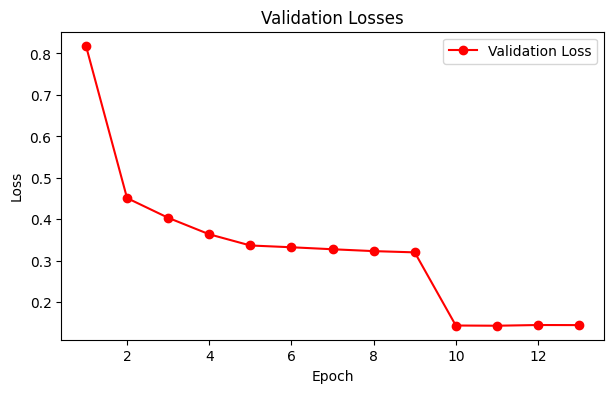

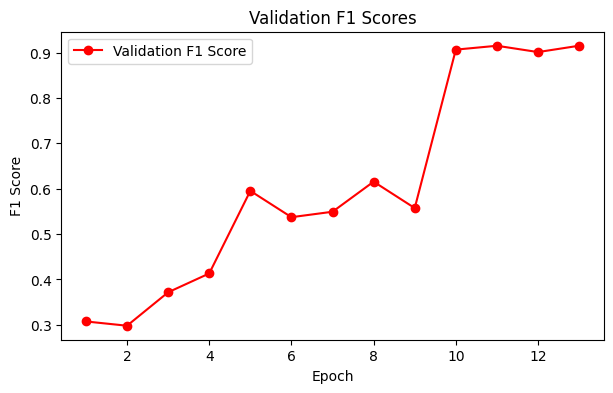

In [ ]:
import matplotlib.pyplot as plt

# sample 13 epochs
epochs = [1, 2, 3, 4,5,6,7,8,9,10,11,12,13]
val_values = [0.3074, 0.298, 0.3717, 0.4132, 0.5952, 0.5372, 0.5492, 0.6155, 0.5573, 0.9065, 0.915, 0.9011, 0.9151]
losses = [0.8187, 0.4513, 0.4038, 0.3640, 0.3370, 0.3327, 0.3279, 0.3234, 0.3204, 0.1440, 0.1435, 0.1452, 0.1450]

def ploty(title, title_plural, val_values, epochs):
    plt.figure(figsize=(7, 4))
    plt.plot(epochs, val_values, 'ro-', label=f'Validation {title}')
    plt.title(f'Validation {title_plural}')
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()
    plt.show()

# Plotting training and validation losses
ploty(
    title="Loss",
    title_plural = "Losses",
    val_values = losses,
    epochs = epochs
)

ploty(
    title="F1 Score",
    title_plural = "F1 Scores",
    val_values = val_values,
    epochs = epochs
)

In [ ]:
from flair.models import SequenceTagger

# Load the trained model
model = SequenceTagger.load('best-model.pt')

# Assuming you've already created a corpus with test data
# test_data = corpus.test

2024-01-07 18:04:30,988 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>


In [ ]:
from flair.data import Sentence

# Example: Predicting tags for a single sentence
sentence = Sentence('''Maximum travel distances Location Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1 9 1 18 Areas with seating in rows 1 15 1 32 Areas not listed above 1 18 1 45 Ground storey of small premises with a single exit 1 27 N/A Notes: 1''')
model.predict(sentence)
print(sentence.to_tagged_string())


Sentence[70]: "Maximum travel distances Location Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1 9 1 18 Areas with seating in rows 1 15 1 32 Areas not listed above 1 18 1 45 Ground storey of small premises with a single exit 1 27 N/A Notes: 1" → ["Maximum travel distances Location Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1 9"/Requirement, "1"/Exception, "18"/Exception, "Areas with seating in rows 1"/Requirement, "15"/Exception, "1"/Exception, "32"/Exception, "Areas not listed above 1 18 1 45 Ground storey of small premises with a single exit 1 27 N/A Notes: 1"/Requirement]


In [ ]:
from flair.data import Sentence

# Example: Predicting tags for a single sentence
sentence = Sentence('''In certain conditions, typically classrooms, a single direction of escape (a dead end condition) can be accepted as providing reasonable safety providing that the recommendations of Table 1 on travel distances in a single direction is met and the occupancy of the space is limited to 60. Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1 9 1 1 18 1 Areas with seating in rows 1 15 1 1 32 1 Areas not listed above 1 18 1 1 45 1''')
model.predict(sentence)
print(sentence.to_tagged_string())


Sentence[107]: "In certain conditions, typically classrooms, a single direction of escape (a dead end condition) can be accepted as providing reasonable safety providing that the recommendations of Table 1 on travel distances in a single direction is met and the occupancy of the space is limited to 60. Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1 9 1 1 18 1 Areas with seating in rows 1 15 1 1 32 1 Areas not listed above 1 18 1 1 45 1" → ["In certain conditions, typically classrooms, a single direction of escape (a dead end condition) can be accepted as providing reasonable safety providing that the recommendations of Table 1 on travel distances in a single direction is met and the occupancy of the space is limited to 60. Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1"/Requirement, "9"/Exception, "1"/Exc

In [ ]:
!pip install pymupdf

In [ ]:
pip install python-docx

In [ ]:
import fitz  # PyMuPDF
from docx import Document
from bs4 import BeautifulSoup


def getText(file_path):
    file_extension = file_path.split('.')[-1].lower()

    # Extract text based on file extension
    if file_extension == 'pdf':
        text = extract_text_from_pdf(file_path)
    elif file_extension == 'docx':
        text = extract_text_from_docx(file_path)
    elif file_extension == 'html':
        text = extract_text_from_html(file_path)
    else:
        text = "Unsupported file format"

    return text


def extract_text_from_pdf(file_path):
    text = ''
    try:
        pdf_document = fitz.open(file_path)
        for page in pdf_document:
            text += page.get_text()
    except Exception as e:
        text = f"Error reading PDF: {str(e)}"
    return text


def extract_text_from_docx(file_path):
    text = ''
    try:
        doc = Document(file_path)
        for para in doc.paragraphs:
            text += para.text
    except Exception as e:
        text = f"Error reading DOCX: {str(e)}"
    return text


def extract_text_from_html(file_path):
    text = ''
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            html_content = file.read()
            soup = BeautifulSoup(html_content, 'html.parser')
            # Get text from the HTML content (excluding tags)
            text = soup.get_text(separator=' ', strip=True)
    except Exception as e:
        text = f"Error reading HTML: {str(e)}"
    return text







In [ ]:
from flair.models import SequenceTagger
from flair.data import Sentence
import os
import pathlib
import sys
import re



def infer(text):
    # Load the trained model
    path = f'best-model.pt'
    model = SequenceTagger.load(path)

    text_split = text.split(".")

    final_string = ""
    a = []
    for x in text_split:
        sentence = Sentence(x)
        model.predict(sentence)
        value = sentence.to_tagged_string()
        a.append(value)
        value_split = value.split('\u2192')[-1]



        pattern = r'"([^"]*)"/\w+'
        extracted_items = re.findall(pattern, value_split)

        pattern_2 = r'"/([A-Z][a-z]*)'
        extracted_items_tags =  re.findall(pattern_2, value_split)


        for i, item in enumerate(extracted_items):
            final_string += f"{extracted_items_tags[i]}: {item} \n"


    return final_string



In [ ]:
print(infer('''In certain conditions, typically classrooms, a single direction of escape (a dead end condition) can be accepted as providing reasonable safety providing that the recommendations of Table 1 on travel distances in a single direction is met and the occupancy of the space is limited to 60. Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1 9 1 1 18 1 Areas with seating in rows 1 15 1 1 32 1 Areas not listed above 1 18 1 1 45 1'''))

2024-01-07 18:06:07,151 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>
Requirement: In certain conditions, typically classrooms, a single direction of escape (a dead end condition) can be accepted as providing reasonable safety providing that the recommendations of Table 1 on travel distances in a single direction is met and the occupancy of the space is limited to 60 
Requirement: Where travel is possible in one direction only (m) Where travel is possible in more than one direction (m) Places of special fire hazard 1 
Exception: 9 
Exception: 1 
Exception: 1 
Exception: 18 
Exception: 1 
Requirement: Areas with seating in rows 1 
Exception: 15 
Exception: 1 
Exception: 1 
Exception: 32 
Exception: 1 
Application: Areas 
Requirement: not listed above 1 18 
Exception: 1 
Exception: 1 
Exception: 45 
Exception: 1 



In [ ]:
print(infer(getText("BB100-Section4.html")))

In [ ]:
print(infer('''conditions'''))

2024-01-07 18:17:27,224 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>
Application: conditions 



In [ ]:
print(infer('''Where travel is possible in more than one direction (m)'''))

2024-01-07 18:18:02,011 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>
Requirement: Where travel is possible in more than one direction (m) 



In [ ]:
print(infer('''Areas'''))

2024-01-07 18:19:52,086 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>
Application: Areas 



In [ ]:
print(infer('''Areas not listed above'''))

2024-01-07 18:20:20,181 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>
Requirement: Areas not listed above 



In [ ]:
print(infer('''a suitably sited'''))

2024-01-07 18:23:24,943 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>
Exception: a suitably sited 



In [ ]:
print(infer(''''''))

2024-01-07 18:30:24,556 SequenceTagger predicts: Dictionary with 11 tags: O, B-Requirement, I-Requirement, B-Application, I-Application, B-Exception, I-Exception, B-Selection, I-Selection, <START>, <STOP>
2024-01-07 18:30:24,679 Warning: An empty Sentence was created! Are there empty strings in your dataset?

